## Library

In [1]:
import os
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
from datetime import datetime as dt
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
MAX_YEAR = CURRENT_YEAR + 100                     # What year to end the run on? (CURRENT_YEAR defined in utils.py)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "(1B) Minimal Menace Anchors" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/pasta.sqcache.npy'))))
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

Cache from: 2024-04-26 10:09:54.909657


{1: 24.799000000000003,
 5: 26.1,
 10: 26.7,
 20: 28.2,
 30: 30.2,
 40: 32.1,
 50: 33.9,
 60: 35.8,
 70: 37.9,
 80: 40.3,
 90: 43.9,
 95: 47.0,
 99: 53.2}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "(3A) Initial TAI Spend Model" notebook
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/initial_pay.sqcache.npy'))))
initial_pay = [round(p, 1) for p in initial_pay]
sq.get_percentiles(initial_pay)

Cache from: 2024-04-26 10:07:34.088634


{1: 8.1,
 5: 8.3,
 10: 8.4,
 20: 8.5,
 30: 8.6,
 40: 8.7,
 50: 8.8,
 60: 8.9,
 70: 9.0,
 80: 9.2,
 90: 9.5,
 95: 9.7,
 99: 10.001000000000204}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)
print('Cache from: {}'.format(dt.fromtimestamp(os.path.getmtime('caches/nonscaling_delays.dill'))))

delay

Cache from: 2024-04-26 10:13:32.481876


{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) (version 0.28-dev1)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(lognorm_mean=2.52, lognorm_sd=1.31, norm_mean=0.8, norm_sd=0.49) (version 0.28-dev1)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.45, lognorm_sd=2.42, norm_mean=1.04, norm_sd=0.63)
   - 0.1 weight on <Distribution> lognorm(lognorm_mean=5.86, lognorm_sd=2.22, norm_mean=1.7, norm_sd=0.37) (version 0.28-dev1)},
 'robotics': {'pro

In [6]:
def wildeford_max_gdp_frac():
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.8:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.015, 0.8, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.99, lclip=0.1, rclip=0.999)
        percent_spent_on_largest_model = sq.lognorm(0.01, 0.8, rclip=0.999)

    frac = ~gdp_frac * ~percent_spent_on_compute * ~percent_spent_on_largest_model
    frac = 1 / (4*K) if frac < (1 / (4*K)) else frac
    gpd_frac = 1 / (4*K) if gdp_frac < (1 / (4*K)) else gdp_frac
    return {'total_frac': gdp_frac, 'compute_frac': frac}


# https://forum.effectivealtruism.org/posts/ccw9v9giKxg8nyLhp/xpt-forecasts-on-some-biological-anchors-inputs
variables = {'initial_gdp': 23.32*T * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03) * sq.lognorm(1.02, 1.03),
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': sq.lognorm(0.75, 3),
             'algo_doubling_rate_min': sq.lognorm(0.5, 2),
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': sq.norm(18.2, 19.4),  # https://docs.google.com/spreadsheets/d/1cLzO_tX9b4z6URKLFvzc0MtsN4GrftkFZuv1bCxeWVY/edit#gid=2058539694
             'flop_halving_rate': sq.norm(2, 3),      # https://epochai.org/blog/trends-in-gpu-price-performance and https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.norm(21, 26),  # https://epochai.org/blog/predicting-gpu-performance and https://asteriskmag.com/issues/03/the-transistor-cliff
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': lambda: wildeford_max_gdp_frac()['compute_frac'], # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.lognorm(1, 3, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

#### Total % of GDP spent on entire project

In [7]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['total_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 56409.32it/s]


{1: 0.00069,
 5: 0.00105,
 10: 0.00132,
 20: 0.00176,
 30: 0.00215,
 40: 0.00259,
 50: 0.00311,
 60: 0.0038,
 70: 0.00489,
 80: 0.00744,
 90: 0.01143,
 95: 0.01438,
 99: 0.01994}

In [8]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.069%',
 5: '0.105%',
 10: '0.132%',
 20: '0.176%',
 30: '0.215%',
 40: '0.259%',
 50: '0.311%',
 60: '0.38%',
 70: '0.489%',
 80: '0.744%',
 90: '1.143%',
 95: '1.438%',
 99: '1.994%'}

In [9]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '17.3 billion',
 5: '26.3 billion',
 10: '33.2 billion',
 20: '44.2 billion',
 30: '54.0 billion',
 40: '65.0 billion',
 50: '77.9 billion',
 60: '95.6 billion',
 70: '123.1 billion',
 80: '186.4 billion',
 90: '287.3 billion',
 95: '360.8 billion',
 99: '501.3 billion'}

#### Total GDP spent on compute for largest model

In [10]:
gdp_frac_samples = sq.sample(lambda: wildeford_max_gdp_frac()['compute_frac'], verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 966741.35it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.00025,
 60: 0.00037,
 70: 0.00055,
 80: 0.00089,
 90: 0.00172,
 95: 0.00272,
 99: 0.00673}

In [11]:
dict([(k, '{}%'.format(round(v * 100, 3))) for k, v in sq.get_percentiles(gdp_frac_samples, digits=5).items()])

{1: '0.025%',
 5: '0.025%',
 10: '0.025%',
 20: '0.025%',
 30: '0.025%',
 40: '0.025%',
 50: '0.025%',
 60: '0.037%',
 70: '0.055%',
 80: '0.089%',
 90: '0.172%',
 95: '0.272%',
 99: '0.673%'}

In [12]:
gdp_samples = sq.sample(variables['initial_gdp'], n=5000) * gdp_frac_samples
{k: numerize(v) for k, v in sq.get_percentiles(gdp_samples).items()}

{1: '6.2 billion',
 5: '6.2 billion',
 10: '6.3 billion',
 20: '6.3 billion',
 30: '6.3 billion',
 40: '6.3 billion',
 50: '6.4 billion',
 60: '9.4 billion',
 70: '13.9 billion',
 80: '22.4 billion',
 90: '43.3 billion',
 95: '68.4 billion',
 99: '169.2 billion'}

## Run Wildeford timelines model



## SAMPLE RUN 1 ##

In this simulation:
* It takes 39.9 log FLOP (~7.9 million decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3.7 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~17.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~141.8 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~245.5 million).
* This doubles every 1.5 year to a max of 0.043573% of GDP (initially ~10.9 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 39.9 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 8.4 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 39.4 logFLOP which costs 20.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.9 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 39.0 logFLOP which costs 19.5 log 2025$USD to buy vs. WTP at 8.8 (buys 28.3 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 38.5 logFLOP wh

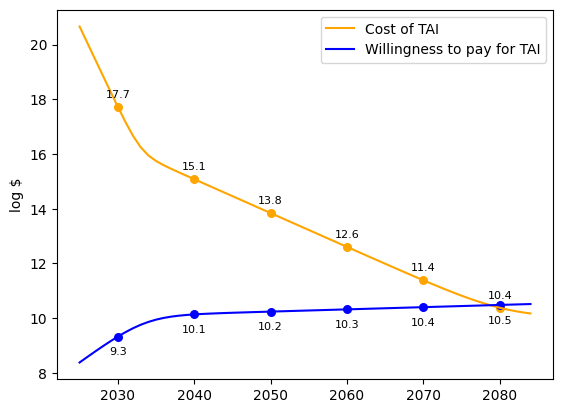



## SAMPLE RUN 2 ##

In this simulation:
* It takes 30.0 log FLOP (~1.0 nonillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.7 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.3 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~313.8 million).
* This doubles every 1.9 year to a max of 0.163451% of GDP (initially ~41.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 30.0 logFLOP which costs 11.2 log 2025$USD to buy vs. WTP at 8.5 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 29.8 logFLOP which costs 10.9 log 2025$USD to buy vs. WTP at 8.7 (buys 27.6 log FLOP or 27.8 2025-log-eFLOP)
2027 - TAI takes 29.6 logFLOP which costs 10.6 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 29.4 logFLOP which costs 10.

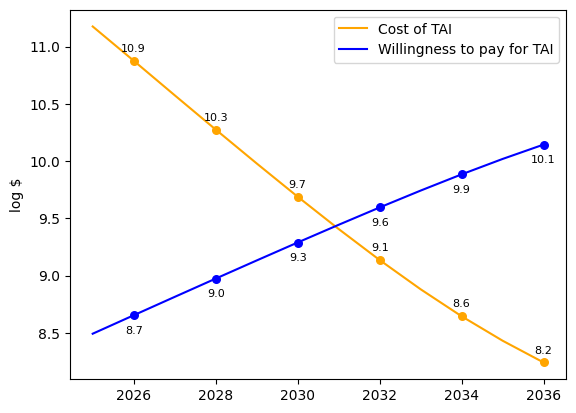



## SAMPLE RUN 3 ##

In this simulation:
* It takes 41.5 log FLOP (~316.2 million decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.3 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~823.5 quintillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.5 billion).
* This doubles every 1.7 year to a max of 0.031323% of GDP (initially ~7.8 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 41.5 logFLOP which costs 23.1 log 2025$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 41.0 logFLOP which costs 22.6 log 2025$USD to buy vs. WTP at 9.5 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 40.6 logFLOP which costs 22.0 log 2025$USD to buy vs. WTP at 9.6 (buys 28.2 log FLOP or 29.1 2025-log-eFLOP)
2028 - TAI takes 40.1 logFLOP which

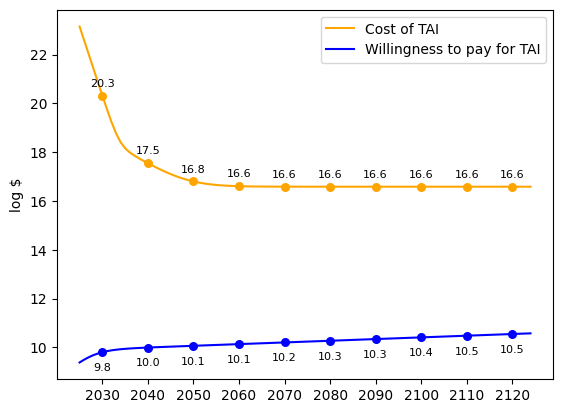



## RUN TIMELINES MODEL ##
Generating Bayes net with 12 cores...


10044it [00:14, 672.17it/s]                                                                                                                                                                                                                          


Shuffling data...
Writing data...
Waiting for other cores...
...Collecting data...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 1136.77it/s]

...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!

## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2031',
 '10%: 2033',
 '15%: 2034',
 '20%: 2036',
 '25%: 2038',
 '35%: 2042',
 '50%: 2054',
 '60%: 2067',
 '75%: >2125',
 '80%: >2125',
 '90%: >2125',
 '95%: >2125']


## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 6 years from now',
 '10%: 8 years from now',
 '15%: 9 years from now',
 '20%: 11 years from now',
 '25%: 13 years from now',
 '35%: 17 years from now',
 '50%: 29 years from now',
 '60%: 42 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 47 years from now)


## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2026-2027: 0.6%
2028-2030: 3.7%
2030-2034: 12.7%
2035-2039: 13.6%
2040-2049: 16.2%
2050-2059: 10.4%
2060-2069: 6.3%
2070-2079: 3.3%
2080-2089: 1.6%
2090-2099: 1.1%
2100-2109: 0.6%
2110-2119: 



## GDP Over Time ##
Year: 2025 - GDP log 2024$USD 13.4 (~25.1 trillion) 80% CI 13.4 (~25.0 trillion) - 13.4 (~25.2 trillion)
Year: 2026 - GDP log 2024$USD 13.4 (~25.7 trillion) 80% CI 13.4 (~25.4 trillion) - 13.4 (~26.0 trillion)
Year: 2027 - GDP log 2024$USD 13.4 (~26.3 trillion) 80% CI 13.4 (~25.8 trillion) - 13.4 (~26.7 trillion)
Year: 2028 - GDP log 2024$USD 13.4 (~26.9 trillion) 80% CI 13.4 (~26.3 trillion) - 13.4 (~27.5 trillion)
Year: 2029 - GDP log 2024$USD 13.4 (~27.5 trillion) 80% CI 13.4 (~26.7 trillion) - 13.5 (~28.3 trillion)
Year: 2030 - GDP log 2024$USD 13.4 (~28.1 trillion) 80% CI 13.4 (~27.1 trillion) - 13.5 (~29.1 trillion)
Year: 2031 - GDP log 2024$USD 13.5 (~28.8 trillion) 80% CI 13.4 (~27.6 trillion) - 13.5 (~30.0 trillion)
Year: 2032 - GDP log 2024$USD 13.5 (~29.4 trillion) 80% CI 13.4 (~28.0 trillion) - 13.5 (~30.9 trillion)
Year: 2033 - GDP log 2024$USD 13.5 (~30.1 trillion) 80% CI 13.5 (~28.5 trillion) - 13.5 (~31.8 trillion)
Year: 2034 - GDP log 2024$USD 13.

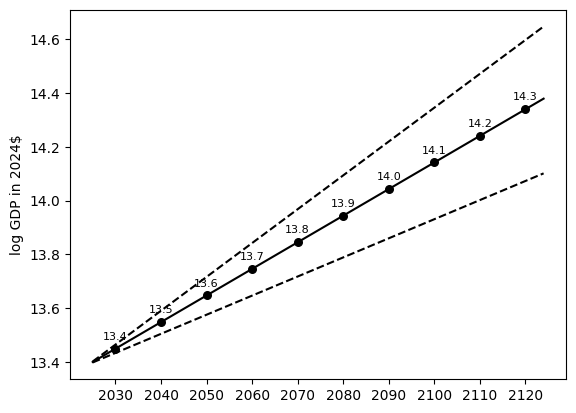

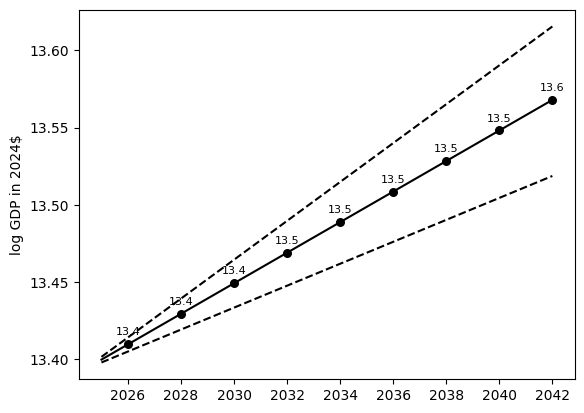



## Willingness to Pay Over Time ##
Year: 2025 - willingness log 2024$USD per year 8.8 (~574.6 million) 80% CI 8.5 (~301.0 million) - 9.2 (~1.5 billion)
Year: 2026 - willingness log 2024$USD per year 8.9 (~833.6 million) 80% CI 8.7 (~504.2 million) - 9.3 (~2.0 billion)
Year: 2027 - willingness log 2024$USD per year 9.1 (~1.2 billion) 80% CI 8.9 (~827.0 million) - 9.4 (~2.7 billion)
Year: 2028 - willingness log 2024$USD per year 9.2 (~1.7 billion) 80% CI 9.1 (~1.3 billion) - 9.5 (~3.5 billion)
Year: 2029 - willingness log 2024$USD per year 9.4 (~2.2 billion) 80% CI 9.3 (~2.0 billion) - 9.7 (~4.6 billion)
Year: 2030 - willingness log 2024$USD per year 9.5 (~3.0 billion) 80% CI 9.5 (~2.9 billion) - 9.8 (~6.0 billion)
Year: 2031 - willingness log 2024$USD per year 9.6 (~3.7 billion) 80% CI 9.6 (~3.8 billion) - 9.9 (~7.6 billion)
Year: 2032 - willingness log 2024$USD per year 9.7 (~4.5 billion) 80% CI 9.7 (~4.8 billion) - 10.0 (~9.6 billion)
Year: 2033 - willingness log 2024$USD per year 9

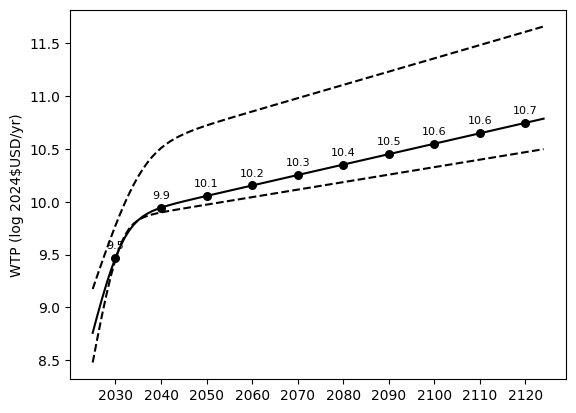

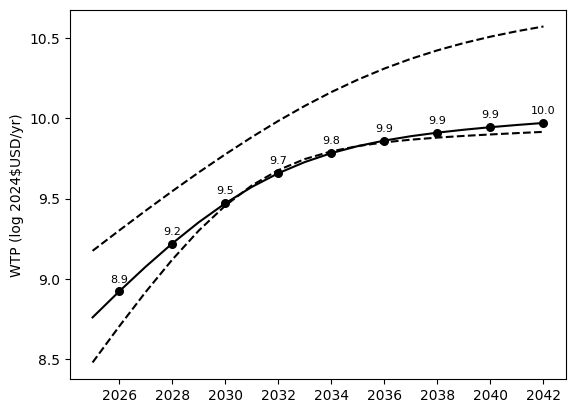



## Actual FLOP Needed to Make TAI (Given Algorithmic Progress) ##
Year: 2025 - logFLOP needed for TAI 33.8 (~6.3 decillion) 80% CI 28.4 (~25.1 octillion) - 40.8 (~63.1 million decillion)
Year: 2026 - logFLOP needed for TAI 33.5 (~3.3 decillion) 80% CI 28.1 (~13.5 octillion) - 40.6 (~39.2 million decillion)
Year: 2027 - logFLOP needed for TAI 33.2 (~1.7 decillion) 80% CI 27.9 (~7.2 octillion) - 40.4 (~24.3 million decillion)
Year: 2028 - logFLOP needed for TAI 32.9 (~891.1 nonillion) 80% CI 27.6 (~3.9 octillion) - 40.2 (~15.1 million decillion)
Year: 2029 - logFLOP needed for TAI 32.7 (~483.9 nonillion) 80% CI 27.3 (~2.2 octillion) - 40.0 (~9.4 million decillion)
Year: 2030 - logFLOP needed for TAI 32.4 (~276.9 nonillion) 80% CI 27.1 (~1.3 octillion) - 39.8 (~5.8 million decillion)
Year: 2031 - logFLOP needed for TAI 32.2 (~171.8 nonillion) 80% CI 26.9 (~791.1 septillion) - 39.6 (~3.6 million decillion)
Year: 2032 - logFLOP needed for TAI 32.1 (~118.3 nonillion) 80% CI 26.7 (~535.9 se

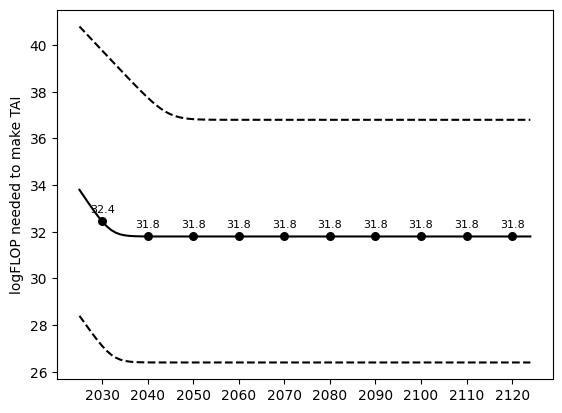

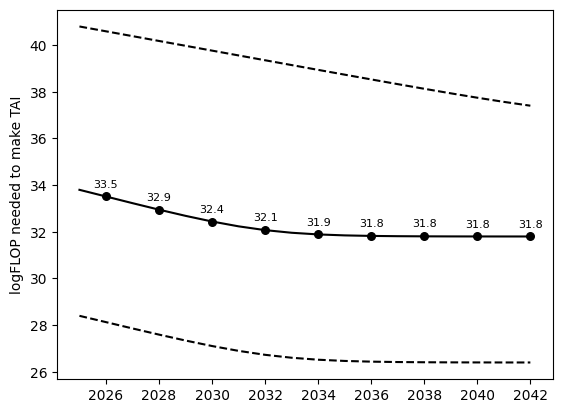



## FLOP per Dollar (Given Declining Costs) ##
Year: 2025 - logFLOP per 2024$1USD 18.8 (~7.0 quintillion) 80% CI 18.5 (~3.5 quintillion) - 19.1 (~13.1 quintillion)
Year: 2026 - logFLOP per 2024$1USD 19.0 (~9.2 quintillion) 80% CI 18.7 (~4.8 quintillion) - 19.2 (~16.9 quintillion)
Year: 2027 - logFLOP per 2024$1USD 19.1 (~12.2 quintillion) 80% CI 18.8 (~6.6 quintillion) - 19.3 (~21.8 quintillion)
Year: 2028 - logFLOP per 2024$1USD 19.2 (~16.1 quintillion) 80% CI 19.0 (~9.0 quintillion) - 19.4 (~28.1 quintillion)
Year: 2029 - logFLOP per 2024$1USD 19.3 (~21.3 quintillion) 80% CI 19.1 (~12.2 quintillion) - 19.6 (~36.2 quintillion)
Year: 2030 - logFLOP per 2024$1USD 19.4 (~28.1 quintillion) 80% CI 19.2 (~16.7 quintillion) - 19.7 (~46.6 quintillion)
Year: 2031 - logFLOP per 2024$1USD 19.6 (~37.2 quintillion) 80% CI 19.4 (~22.7 quintillion) - 19.8 (~60.0 quintillion)
Year: 2032 - logFLOP per 2024$1USD 19.7 (~49.1 quintillion) 80% CI 19.5 (~31.0 quintillion) - 19.9 (~77.3 quintillion)
Year: 

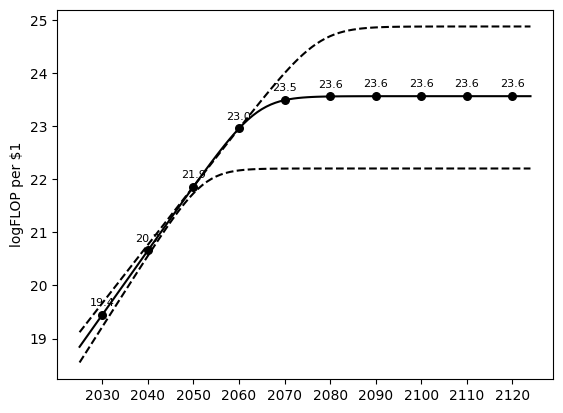

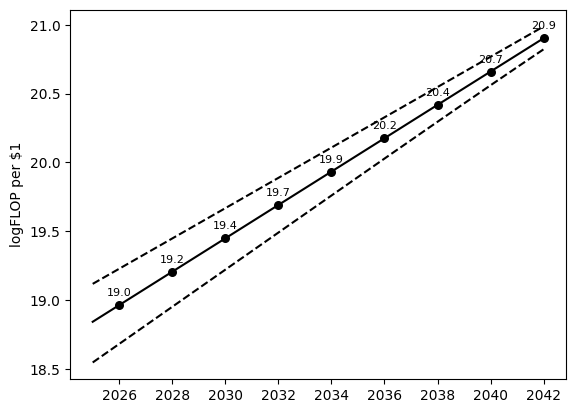



## Max Possible OOM Reduction in TAI FLOP Size ##
TAI log FLOP 20 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (80% CI: 2.0 to 2

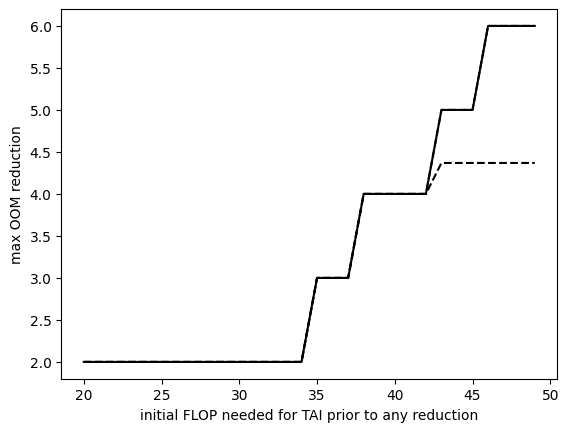



## Halving time (years) of compute requirements ##
TAI log FLOP 20 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 21 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 22 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 23 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 24 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 25 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 26 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 27 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 28 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 29 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 30 -> algo doubling rate 1.51yrs (80% CI: 2.15 to 2.15)
TAI log FLOP 31 -> algo doubling rate 1.02yrs (80% CI: 1.65 to 1.65)
TAI log FLOP 32 -> algo doubling rate 1.02yrs (80% CI: 1.15 to 1.15)
TAI log FLOP 33 -> algo doubling rate 1.02yrs (80%

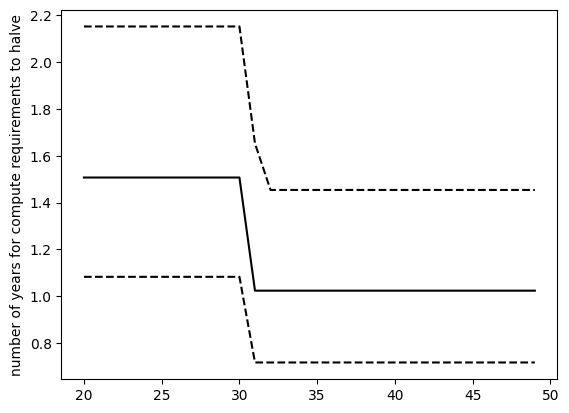



## Dollars Needed to Buy TAI (Given Algorithmic Progress and Decline in Cost per FLOP) ##
Year: 2025 - 15.0 log 2024$USD to buy TAI (~904.6 trillion) 80% CI 9.9 (~7.1 billion) - 21.7 (~4.8 sextillion)
Year: 2026 - 14.5 log 2024$USD to buy TAI (~354.6 trillion) 80% CI 9.4 (~2.8 billion) - 21.4 (~2.3 sextillion)
Year: 2027 - 14.1 log 2024$USD to buy TAI (~138.9 trillion) 80% CI 9.0 (~1.1 billion) - 21.0 (~1.1 sextillion)
Year: 2028 - 13.7 log 2024$USD to buy TAI (~55.3 trillion) 80% CI 8.6 (~439.1 million) - 20.7 (~538.0 quintillion)
Year: 2029 - 13.4 log 2024$USD to buy TAI (~22.7 trillion) 80% CI 8.3 (~179.5 million) - 20.4 (~259.4 quintillion)
Year: 2030 - 13.0 log 2024$USD to buy TAI (~9.8 trillion) 80% CI 7.9 (~76.5 million) - 20.1 (~125.1 quintillion)
Year: 2031 - 12.7 log 2024$USD to buy TAI (~4.6 trillion) 80% CI 7.5 (~34.8 million) - 19.8 (~60.3 quintillion)
Year: 2032 - 12.4 log 2024$USD to buy TAI (~2.4 trillion) 80% CI 7.2 (~17.3 million) - 19.5 (~29.1 quintillion)
Year: 20

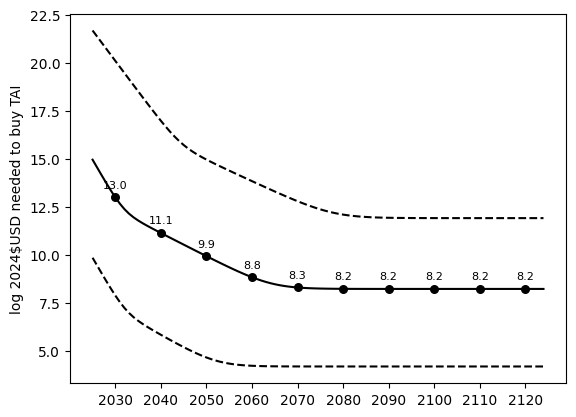

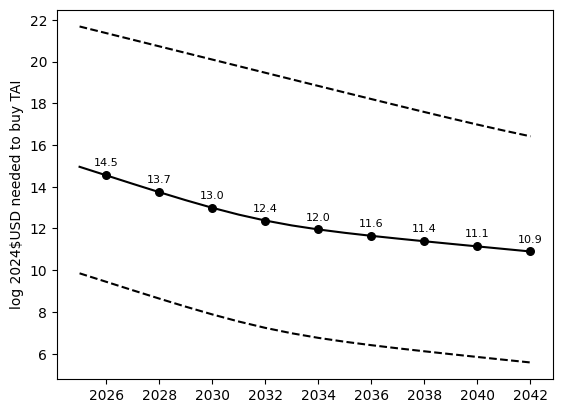



## Actual FLOP at Max Spend ##
Year: 2025 - max log FLOP 27.6 (~4.0 octillion) 80% CI 27.0 (~1.1 octillion) - 28.3 (~19.6 octillion)
Year: 2026 - max log FLOP 27.9 (~7.7 octillion) 80% CI 27.4 (~2.4 octillion) - 28.5 (~33.8 octillion)
Year: 2027 - max log FLOP 28.2 (~14.5 octillion) 80% CI 27.7 (~5.4 octillion) - 28.8 (~58.0 octillion)
Year: 2028 - max log FLOP 28.4 (~26.7 octillion) 80% CI 28.1 (~11.8 octillion) - 29.0 (~98.6 octillion)
Year: 2029 - max log FLOP 28.7 (~47.9 octillion) 80% CI 28.4 (~24.4 octillion) - 29.2 (~166.4 octillion)
Year: 2030 - max log FLOP 28.9 (~83.0 octillion) 80% CI 28.7 (~47.6 octillion) - 29.4 (~277.8 octillion)
Year: 2031 - max log FLOP 29.1 (~138.8 octillion) 80% CI 28.9 (~86.6 octillion) - 29.7 (~458.1 octillion)
Year: 2032 - max log FLOP 29.3 (~223.4 octillion) 80% CI 29.2 (~147.2 octillion) - 29.9 (~744.4 octillion)
Year: 2033 - max log FLOP 29.5 (~346.8 octillion) 80% CI 29.4 (~235.3 octillion) - 30.1 (~1.2 nonillion)
Year: 2034 - max log FLOP 29

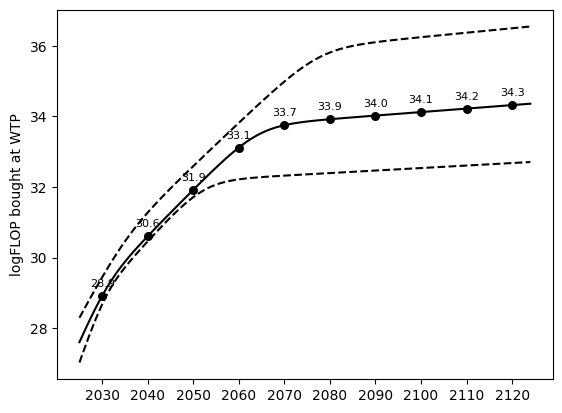

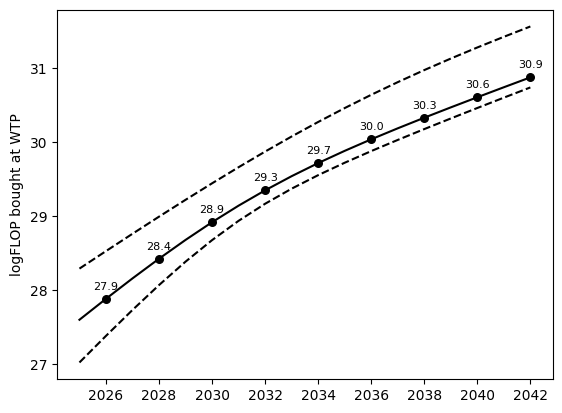



## Effective 2024-FLOP at Max Spend (given algorithmic progress and decline in $/FLOP) ##
Year: 2025 - max log effective 2024-FLOP 27.6 (~4.0 octillion) 80% CI 27.0 (~1.1 octillion) - 28.3 (~19.6 octillion)
Year: 2026 - max log effective 2024-FLOP 28.2 (~14.8 octillion) 80% CI 27.6 (~3.8 octillion) - 28.9 (~88.9 octillion)
Year: 2027 - max log effective 2024-FLOP 28.7 (~54.0 octillion) 80% CI 28.1 (~13.7 octillion) - 29.6 (~400.3 octillion)
Year: 2028 - max log effective 2024-FLOP 29.3 (~189.1 octillion) 80% CI 28.7 (~47.2 octillion) - 30.3 (~1.8 nonillion)
Year: 2029 - max log effective 2024-FLOP 29.8 (~624.3 octillion) 80% CI 29.2 (~153.7 octillion) - 30.9 (~7.9 nonillion)
Year: 2030 - max log effective 2024-FLOP 30.3 (~1.9 nonillion) 80% CI 29.7 (~465.0 octillion) - 31.5 (~34.5 nonillion)
Year: 2031 - max log effective 2024-FLOP 30.7 (~5.1 nonillion) 80% CI 30.1 (~1.3 nonillion) - 32.2 (~146.5 nonillion)
Year: 2032 - max log effective 2024-FLOP 31.1 (~11.9 nonillion) 80% CI 30.5 (

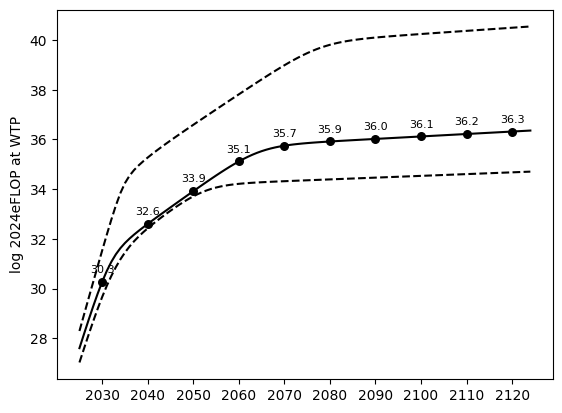

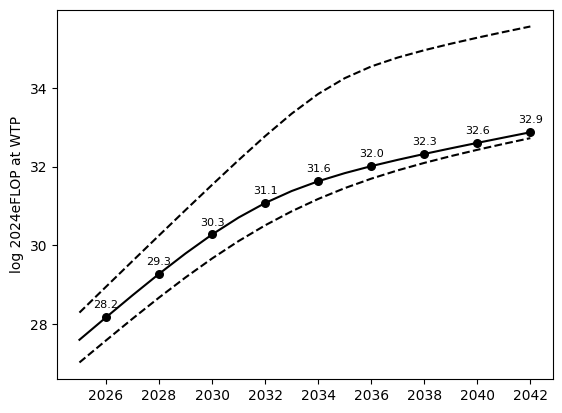


## TAI FLOP SIZE ##
{1: 24.9,
 5: 26.2,
 10: 26.8,
 20: 28.4,
 30: 30.47,
 40: 32.2,
 50: 33.8,
 60: 36.1,
 70: 37.9,
 80: 40.8,
 90: 44.0,
 95: 46.904999999999994,
 99: 54.2}


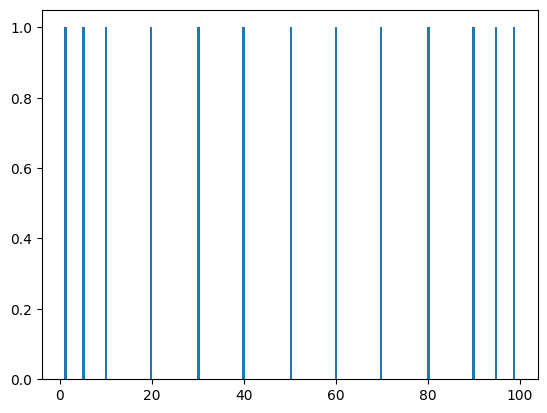



## MIN REDUCTION: 2 ##

## MAX REDUCTION ##
{1: 1.911032496137464,
 5: 2.7908050147375327,
 10: 3.383802627094878,
 20: 4.368645914240857,
 30: 5.203529079593255,
 40: 5.773958042037801,
 50: 6.530373864420054,
 60: 7.488526737145602,
 70: 8.624793971269822,
 80: 10.108533525126958,
 90: 12.701720367271047,
 95: 14.648803839970345,
 99: 21.08719068835762}


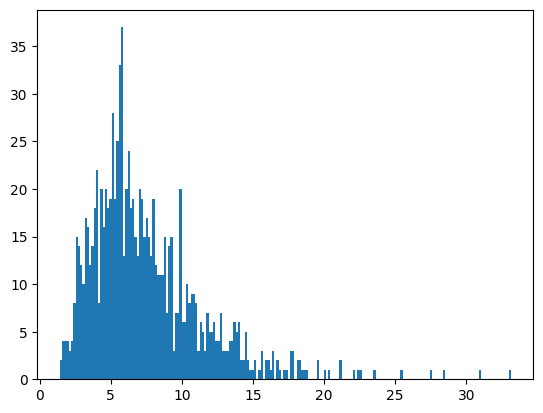



## MIN ALGO DOUBLING RATE ##
{1: 0.3891040501612078,
 5: 0.5207889423308617,
 10: 0.5910712934111044,
 20: 0.71704031908242,
 30: 0.8112786574588305,
 40: 0.9196168615486552,
 50: 1.0239431156172674,
 60: 1.1238535500124156,
 70: 1.2485103788708105,
 80: 1.4543376897877562,
 90: 1.713771246572807,
 95: 1.9946177969335759,
 99: 2.686389801715969}


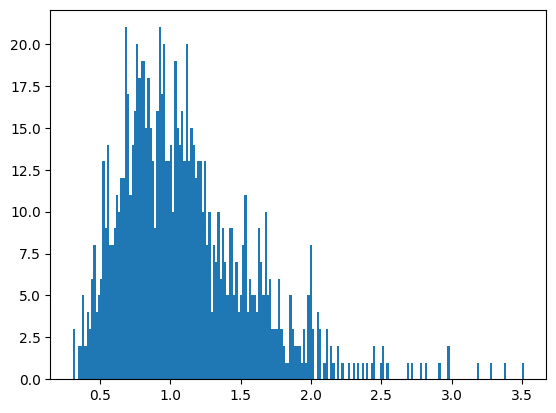



## MAX ALGO DOUBLING RATE ##
{1: 0.579125362625427,
 5: 0.7468107769610717,
 10: 0.9009126517950544,
 20: 1.0830668325089752,
 30: 1.2148472009552176,
 40: 1.349981705147404,
 50: 1.5074376862055499,
 60: 1.689016107608662,
 70: 1.854052915534352,
 80: 2.152915206737659,
 90: 2.579934986133131,
 95: 3.008170725825543,
 99: 3.984874415868289}


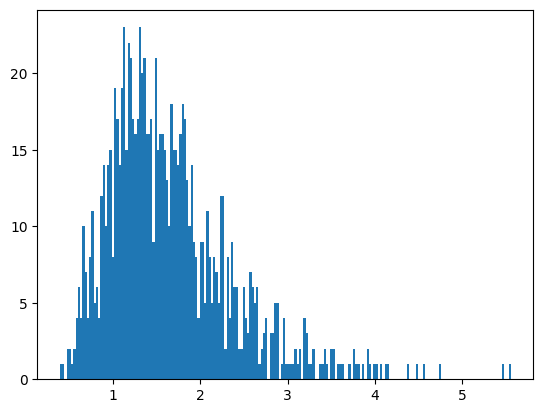



## INITIAL FLOP PER DOLLAR ##
{1: 18.007747614838543,
 5: 18.239219731664544,
 10: 18.371341620948762,
 20: 18.54809943934324,
 30: 18.655451721865614,
 40: 18.747865761691912,
 50: 18.843542471887986,
 60: 18.924625826499728,
 70: 19.012560999284712,
 80: 19.11868249943339,
 90: 19.29345695394503,
 95: 19.42221816020294,
 99: 19.70433162519152}


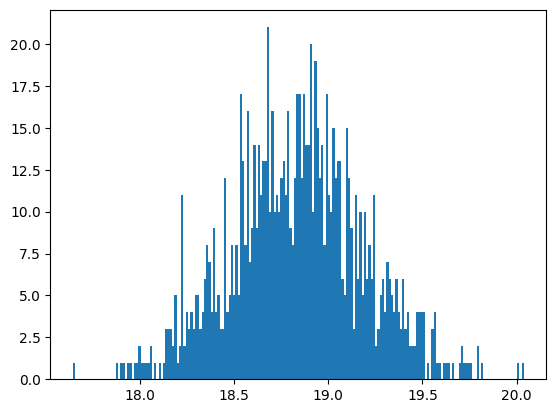



## FLOP HALVING RATE ##
{1: 1.883138532590339,
 5: 2.0187577702843162,
 10: 2.127427658097308,
 20: 2.232911574486297,
 30: 2.3238947299800543,
 40: 2.4051061665334195,
 50: 2.4849308474603893,
 60: 2.562315855872994,
 70: 2.640832287141717,
 80: 2.738532309369399,
 90: 2.8588411725853473,
 95: 3.0061171024080973,
 99: 3.2711316327965547}


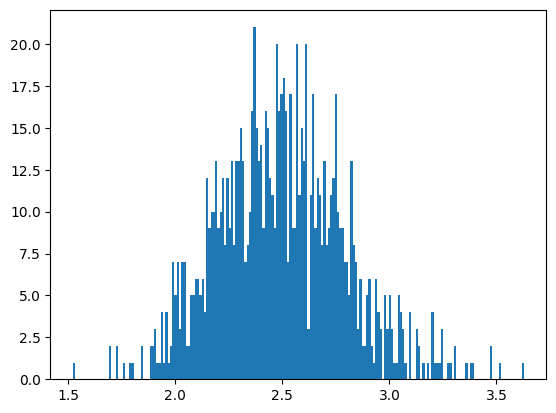



## MAX FLOP PER DOLLAR ##
{1: 20.0155615841171,
 5: 20.969904287928323,
 10: 21.461553571105974,
 20: 22.206538760665694,
 30: 22.756015737914108,
 40: 23.148776191358184,
 50: 23.5703936105728,
 60: 23.996743981379296,
 70: 24.409427585206263,
 80: 24.88499397815001,
 90: 25.510006473229573,
 95: 26.04448727384447,
 99: 27.053263809980496}


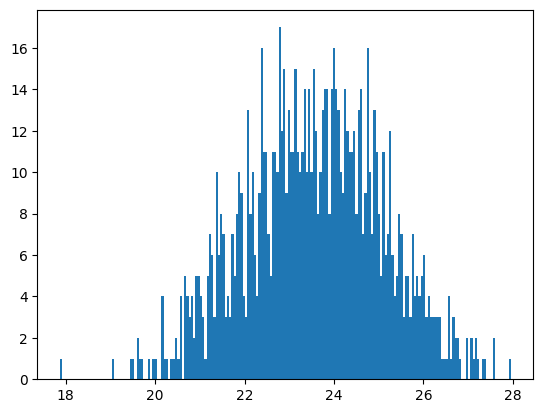



## INITIAL PAY ##
{1: 8.0,
 5: 8.2,
 10: 8.3,
 20: 8.5,
 30: 8.6,
 40: 8.7,
 50: 8.8,
 60: 8.9,
 70: 9.0,
 80: 9.2,
 90: 9.5,
 95: 9.7,
 99: 10.001}


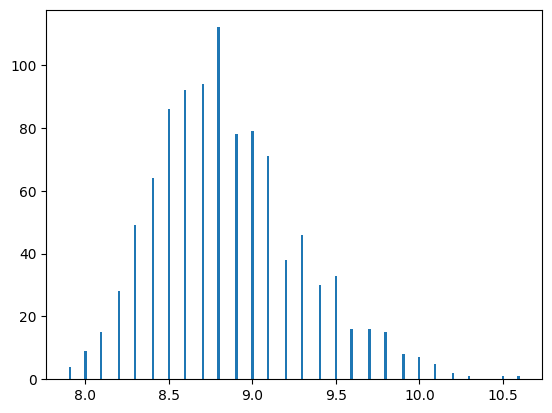



## INITIAL GDP ##
{1: 24798021161613.145,
 5: 24909908776390.664,
 10: 24956691886919.54,
 20: 25003193719118.32,
 30: 25042704056586.098,
 40: 25078320542480.305,
 50: 25110022944183.848,
 60: 25134021125333.375,
 70: 25171759710353.9,
 80: 25213022091663.785,
 90: 25266933884745.66,
 95: 25314198907401.707,
 99: 25394590183591.008}


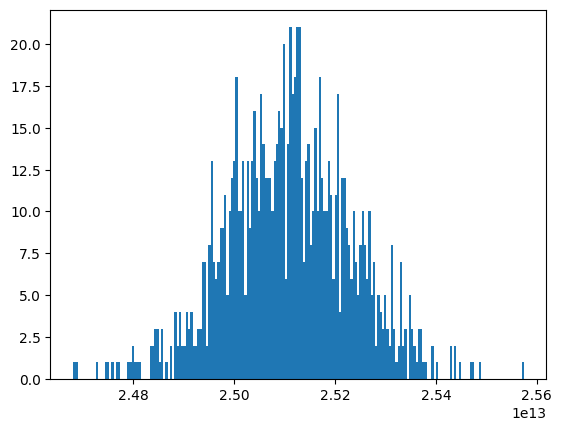



## GDP GROWTH ##
{1: 1.005,
 5: 1.009978409357489,
 10: 1.0123655193015144,
 20: 1.0164846401239285,
 30: 1.0193395069879754,
 40: 1.0214359114278004,
 50: 1.0230277948617195,
 60: 1.024992197012474,
 70: 1.0271750656507714,
 80: 1.029388679216433,
 90: 1.0322907539409172,
 95: 1.035153929876873,
 99: 1.0403588374167279}


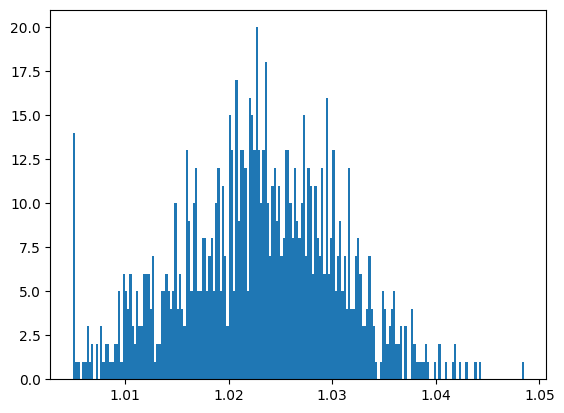



## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00025,
 50: 0.0002564294512801776,
 60: 0.0003980037086672136,
 70: 0.0005729707400459295,
 80: 0.0010325269252182297,
 90: 0.0019120993090429507,
 95: 0.0030007393848444867,
 99: 0.006957837460491179}


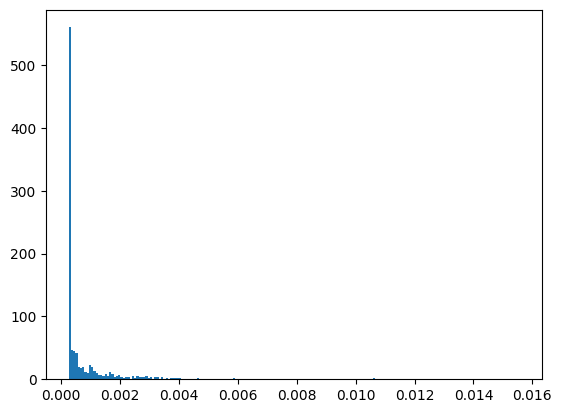



## SPEND DOUBLING TIME ##
{1: 0.9,
 5: 0.9663992639840655,
 10: 1.0913776355416536,
 20: 1.2621053319120468,
 30: 1.3783697875626209,
 40: 1.517337500750047,
 50: 1.6752016115030488,
 60: 1.8194867219938227,
 70: 2.006072011561852,
 80: 2.242096700458488,
 90: 2.6078970593513877,
 95: 2.9598842823214317,
 99: 3.7446628497792673}


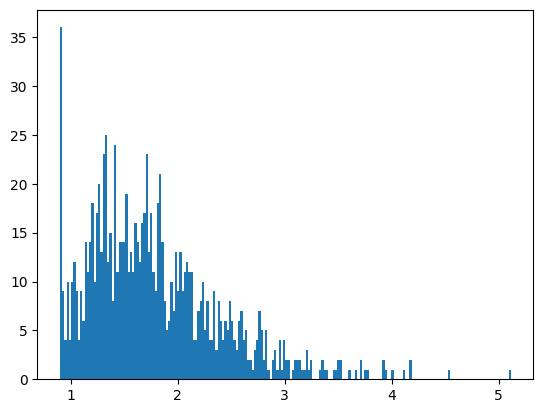





## Nonscaling delay ##
There are 7 ways a non-scaling delay could happen.
- algorithms: additional <Distribution> mixture
 - 0.9 weight on <Distribution> lognorm(lognorm_mean=3.29, lognorm_sd=0.93, norm_mean=1.15, norm_sd=0.28)
 - 0.1 weight on <Distribution> lognorm(lognorm_mean=8.08, lognorm_sd=6.42, norm_mean=1.84, norm_sd=0.7) years if it happens
{1: 2,
 5: 2,
 10: 2,
 20: 2,
 30: 3,
 40: 3,
 50: 3,
 60: 3,
 70: 4,
 80: 4,
 90: 5,
 95: 7,
 99: 14}
## Chance of nonscaling delay ##


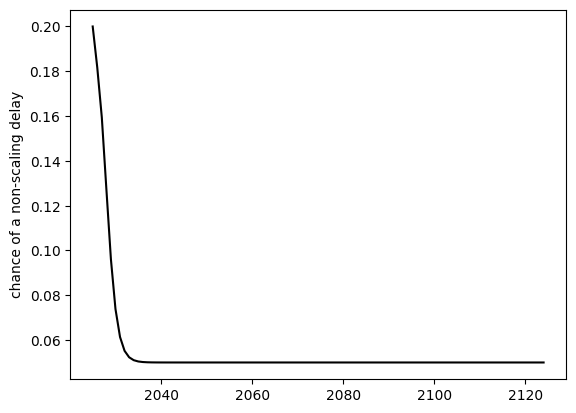

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 13%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - ch

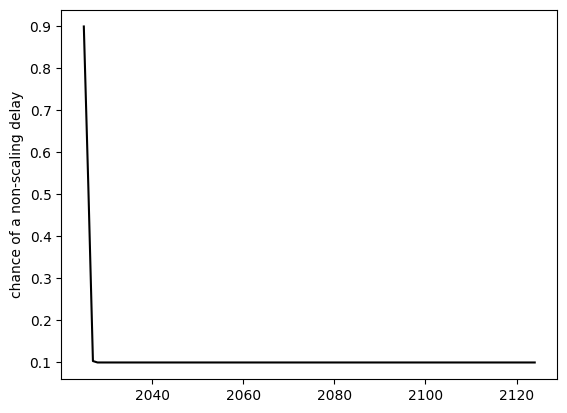

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 52%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

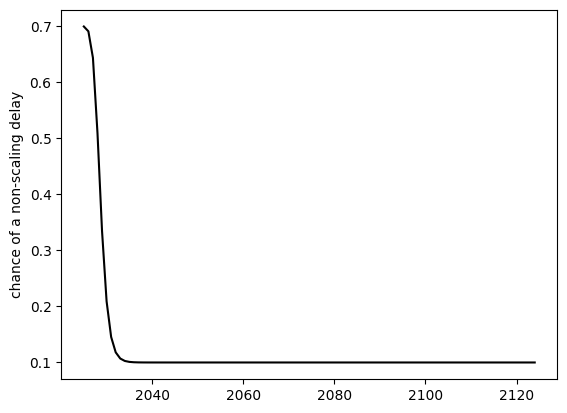

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 69%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 64%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 51%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2035

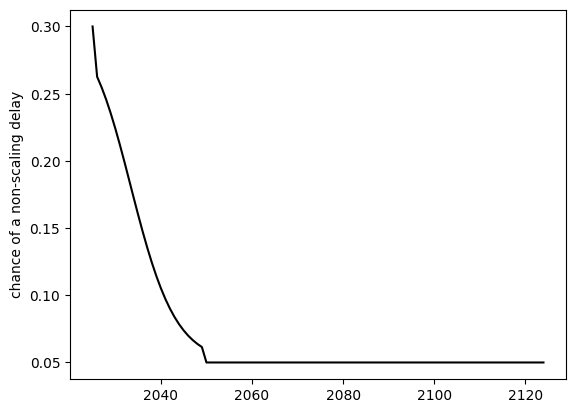

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2035

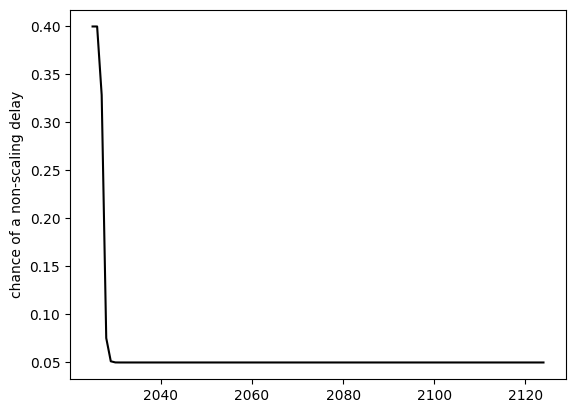

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2035 - chan

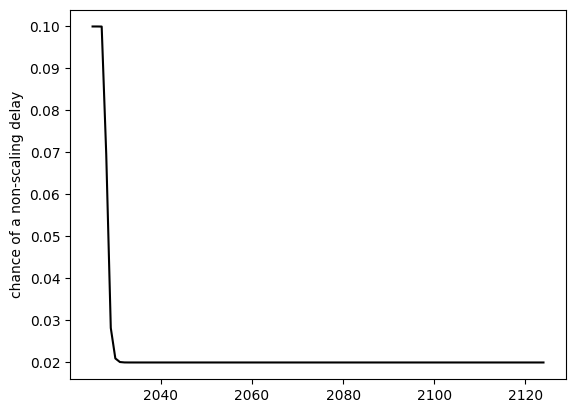

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 3%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2035 - chan

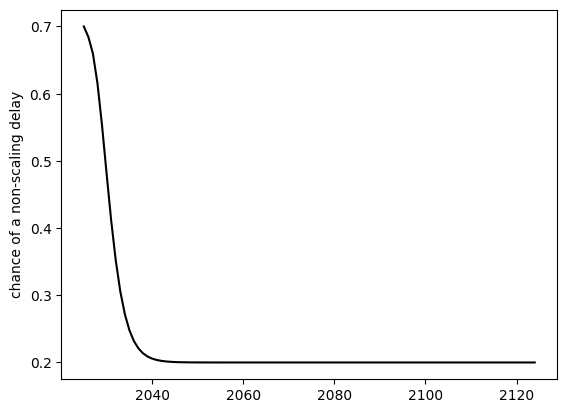

Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 70%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 66%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 41%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 35%
Year: 2033 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 31%
Year: 2034 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2035

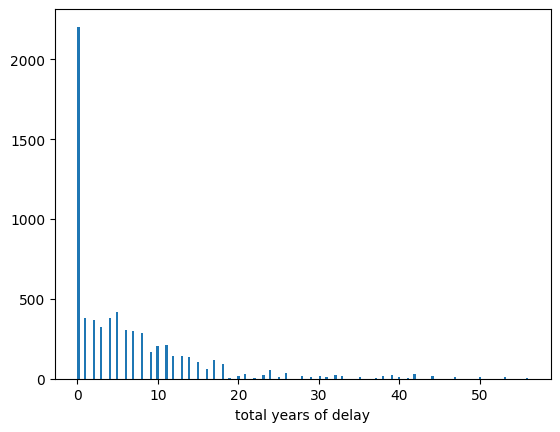

In [17]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=max(1, os.cpu_count() - 2),
                    runs=variables['RUNS'],
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##

In this simulation:
* It takes 34.8 log FLOP (~63.1 decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.8 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~2.6 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~500.1 million).
* This doubles every 1.9 year to a max of 0.930632% of GDP (initially ~235.2 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 34.8 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 34.4 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 34.0 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 33.6 logFLOP which costs

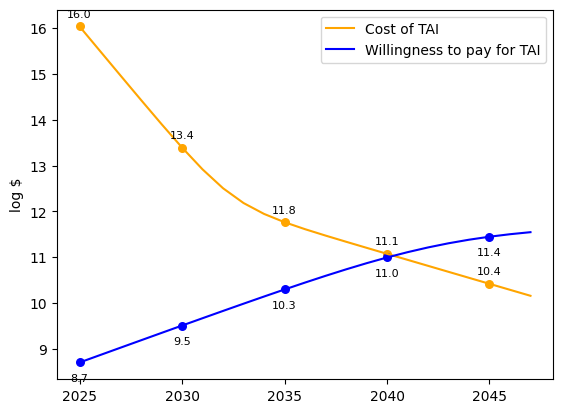

-
-
## SAMPLE RUN 5 ##

In this simulation:
* It takes 51.5 log FLOP (~3.2 quintillion decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.3 quintillion) per 2025$USD.
* Every 2.0 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.0 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 1.4 year to a max of 0.025833% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 51.5 logFLOP which costs 32.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 51.3 logFLOP which costs 32.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 51.1 logFLOP which costs 32.0 log 2025$USD to buy vs. WTP at 9.4 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 50.8 logFLOP whic

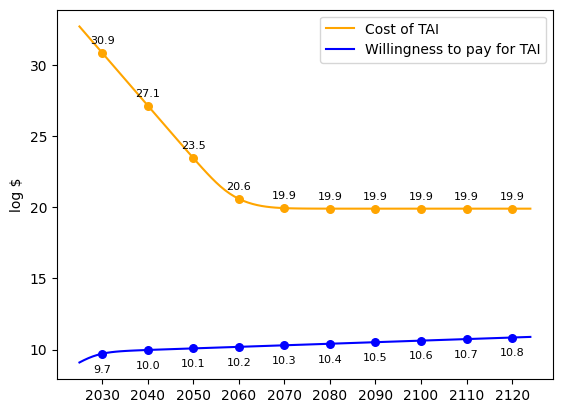

-
-
## SAMPLE RUN 6 ##

In this simulation:
* It takes 34.3 log FLOP (~20.0 decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~71.2 sextillion) per 2025$USD.
* We are initially willing to pay 8.2 log 2025$USD (~154.6 million).
* This doubles every 0.9 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 34.3 logFLOP which costs 15.9 log 2025$USD to buy vs. WTP at 8.2 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 34.0 logFLOP which costs 15.5 log 2025$USD to buy vs. WTP at 8.5 (buys 27.0 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 28.1 2025-log-eFLOP)
2028 - TAI takes 33.4 logFLOP which costs 14.

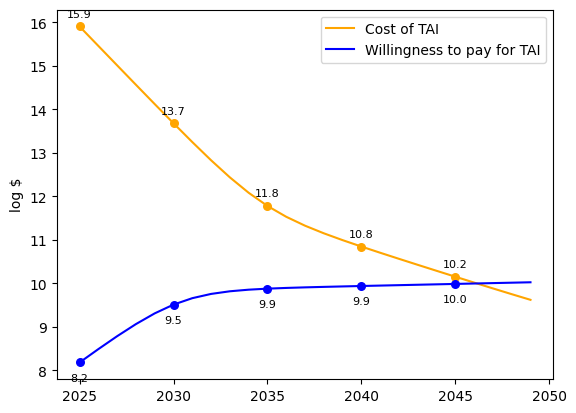

-
-
## SAMPLE RUN 7 ##

In this simulation:
* It takes 40.4 log FLOP (~25.1 million decillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~11.0 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~705.0 million).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 40.4 logFLOP which costs 21.4 log 2025$USD to buy vs. WTP at 8.8 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 40.2 logFLOP which costs 21.0 log 2025$USD to buy vs. WTP at 9.0 (buys 28.2 log FLOP or 28.4 2025-log-eFLOP)
2027 - TAI takes 40.0 logFLOP which costs 20.7 log 2025$USD to buy vs. WTP at 9.2 (buys 28.5 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 39.8 logFLOP which c

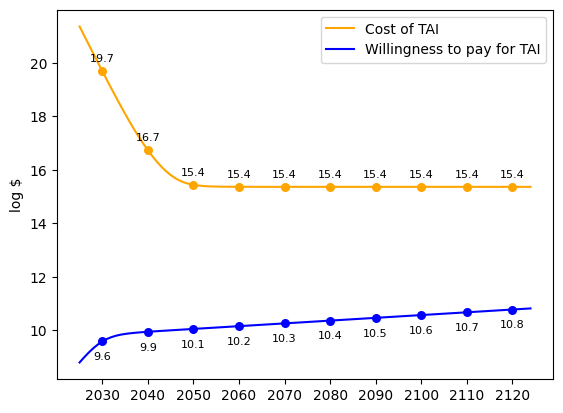

-
-
## SAMPLE RUN 8 ##

In this simulation:
* It takes 27.7 log FLOP (~5.0 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.6 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.2 septillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~489.1 million).
* This doubles every 1.5 year to a max of 0.080031% of GDP (initially ~20.3 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 27.7 logFLOP which costs 9.5 log 2025$USD to buy vs. WTP at 8.7 (buys 26.9 log FLOP or 26.9 2025-log-eFLOP)
2026 - TAI takes 27.4 logFLOP which costs 9.1 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.5 2025-log-eFLOP)
2027 - TAI takes 27.2 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1594 -> N

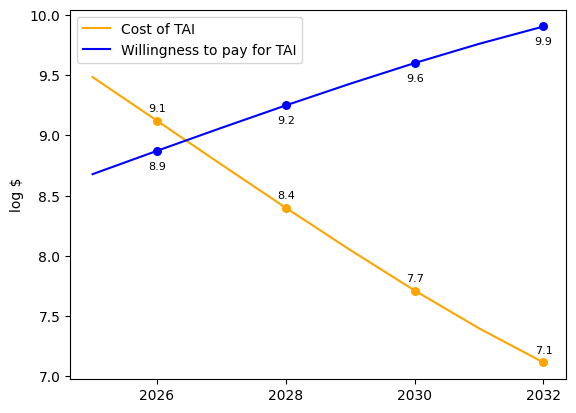

-
-
## SAMPLE RUN 9 ##

In this simulation:
* It takes 25.1 log FLOP (~12.6 septillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~4.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~617.5 million).
* This doubles every 1.6 year to a max of 0.115515% of GDP (initially ~28.9 billion 2025$USD).
* GDP grows at a rate of 1.011x per year.
---
2025 - TAI takes 25.1 logFLOP which costs 6.4 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -

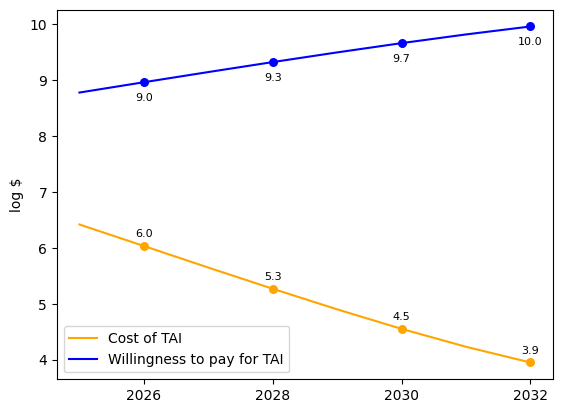

-
-
## SAMPLE RUN 10 ##

In this simulation:
* It takes 52.8 log FLOP (~63.1 quintillion decillion) for transformative capabilities.
* Every 2.0 years algorithms get 2x better, with 7 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~14.8 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~11.8 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.9 million).
* This doubles every 0.9 year to a max of 0.026512% of GDP (initially ~6.6 billion 2025$USD).
* GDP grows at a rate of 1.005x per year.
---
2025 - TAI takes 52.8 logFLOP which costs 33.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 52.6 logFLOP which costs 33.4 log 2025$USD to buy vs. WTP at 8.8 (buys 28.1 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 52.5 logFLOP which costs 33.1 log 2025$USD to buy vs. WTP at 9.1 (buys 28.5 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 52.3 logFLO

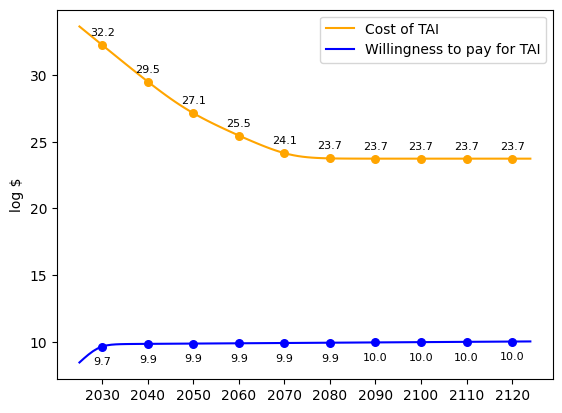

-
-
## SAMPLE RUN 11 ##

In this simulation:
* It takes 38.4 log FLOP (~251.2 thousand decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~174.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.028x per year.
---
2025 - TAI takes 38.4 logFLOP which costs 19.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 38.2 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 37.9 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.1 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 37.7 logFLOP which

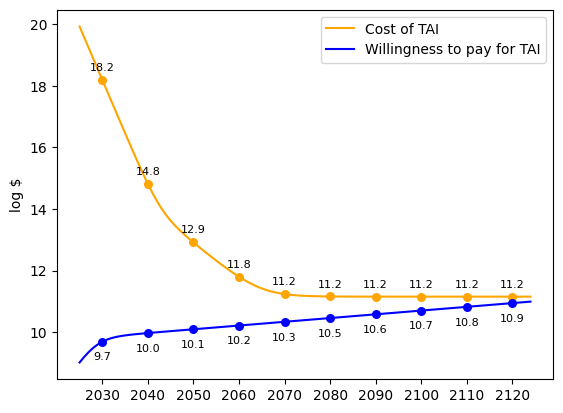

-
-
## SAMPLE RUN 12 ##

In this simulation:
* It takes 34.8 log FLOP (~63.1 decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.9 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 26.3 log FLOP (~196.5 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~704.7 million).
* This doubles every 2.3 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 34.8 logFLOP which costs 16.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 34.5 logFLOP which costs 15.6 log 2025$USD to buy vs. WTP at 8.9 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 34.3 logFLOP which costs 15.2 log 2025$USD to buy vs. WTP at 9.0 (buys 28.1 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 34.0 logFLOP which costs 1

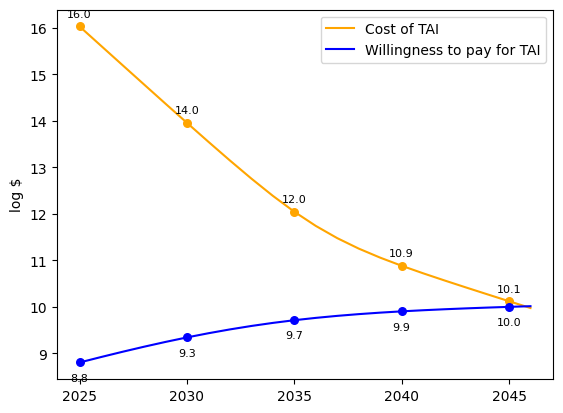

-
-
## SAMPLE RUN 13 ##

In this simulation:
* It takes 27.4 log FLOP (~2.5 octillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.8 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~981.9 million).
* This doubles every 1.6 year to a max of 0.215128% of GDP (initially ~54.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 27.4 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 9.0 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Non

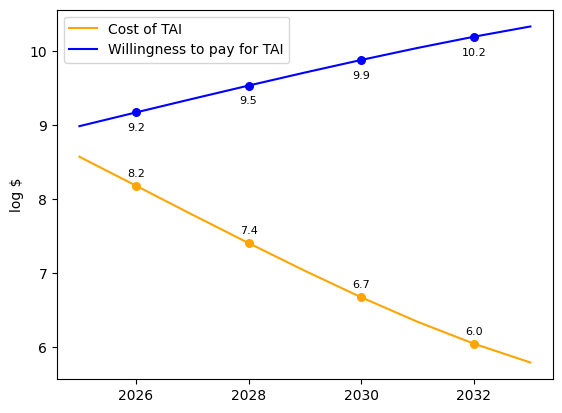

-
-
## SAMPLE RUN 14 ##

In this simulation:
* It takes 29.4 log FLOP (~251.2 octillion) for transformative capabilities.
* Every 1.8 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.7 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~312.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~862.8 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 29.4 logFLOP which costs 10.4 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 29.2 logFLOP which costs 10.2 log 2025$USD to buy vs. WTP at 9.0 (buys 28.1 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 29.1 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.4 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 28.9 logFLOP which costs 9

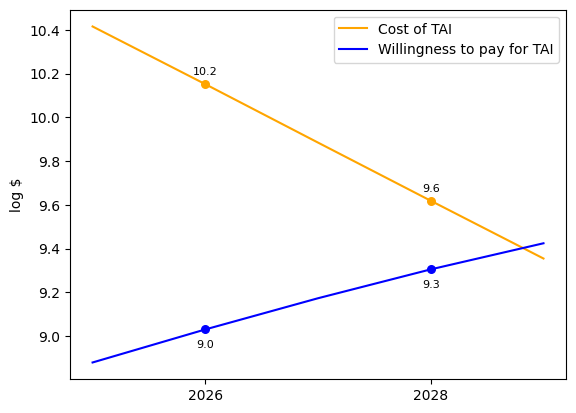

-
-
## SAMPLE RUN 15 ##

In this simulation:
* It takes 42.9 log FLOP (~7.9 billion decillion) for transformative capabilities.
* Every 1.0 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~277.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~474.9 million).
* This doubles every 2.1 year to a max of 0.036028% of GDP (initially ~9.1 billion 2025$USD).
* GDP grows at a rate of 1.012x per year.
---
2025 - TAI takes 42.9 logFLOP which costs 24.2 log 2025$USD to buy vs. WTP at 8.7 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 42.6 logFLOP which costs 23.7 log 2025$USD to buy vs. WTP at 8.8 (buys 27.6 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 42.3 logFLOP which costs 23.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 42.0 logFLOP whi

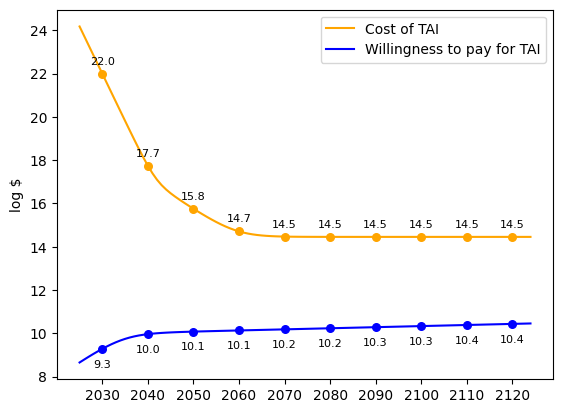

-
-
## SAMPLE RUN 16 ##

In this simulation:
* It takes 42.9 log FLOP (~7.9 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.0 septillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.1 billion).
* This doubles every 1.4 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.02x per year.
---
2025 - TAI takes 42.9 logFLOP which costs 24.6 log 2025$USD to buy vs. WTP at 9.2 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 42.6 logFLOP which costs 24.1 log 2025$USD to buy vs. WTP at 9.4 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 42.2 logFLOP which costs 23.7 log 2025$USD to buy vs. WTP at 9.5 (buys 28.0 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 41.9 logFLOP which costs

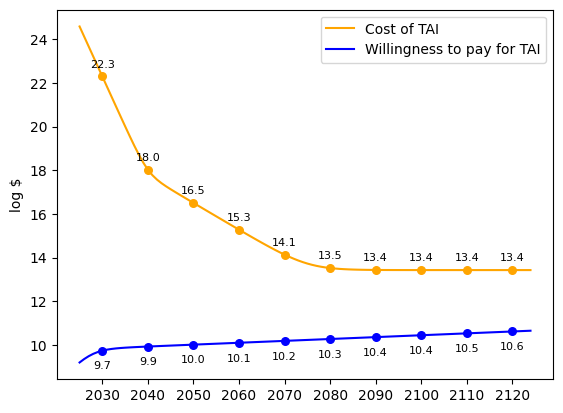

-
-
## SAMPLE RUN 17 ##

In this simulation:
* It takes 31.8 log FLOP (~63.1 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.1 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 25.1 log FLOP (~11.9 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~784.0 million).
* This doubles every 1.0 year to a max of 0.239116% of GDP (initially ~60.3 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 31.8 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 31.5 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 31.3 logFLOP which costs 11.7 log 2025$USD to buy vs. WTP at 9.5 (buys 29.0 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 31.0 logFLOP which cos

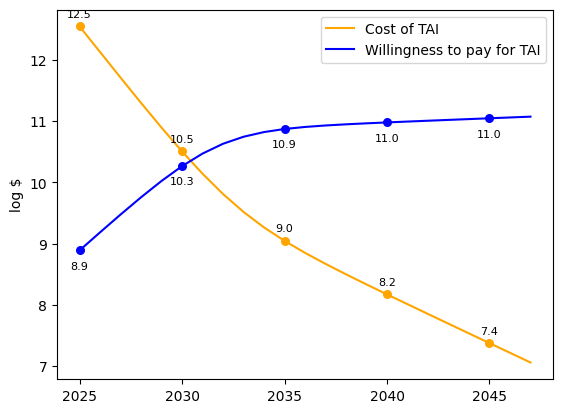

-
-
## SAMPLE RUN 18 ##

In this simulation:
* It takes 34.2 log FLOP (~15.8 decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~24.4 quintillion) per 2025$USD.
* Every 1.8 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~103.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~394.5 million).
* This doubles every 0.9 year to a max of 0.174943% of GDP (initially ~43.9 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 34.2 logFLOP which costs 14.8 log 2025$USD to buy vs. WTP at 8.6 (buys 28.0 log FLOP or 28.0 2025-log-eFLOP)
2026 - TAI takes 34.0 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 8.9 (buys 28.5 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 33.8 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 9.2 (buys 29.0 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 33.6 logFLOP which co

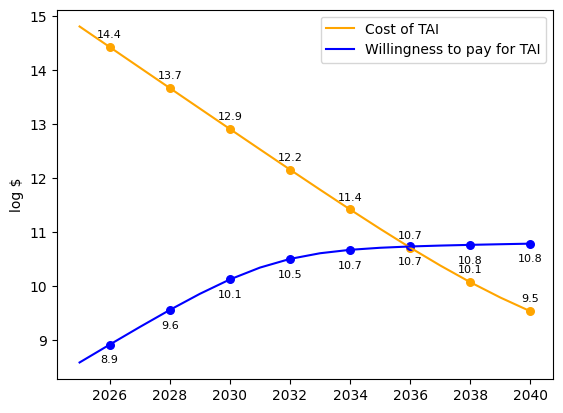

-
-
## SAMPLE RUN 19 ##

In this simulation:
* It takes 44.9 log FLOP (~794.3 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~5.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~115.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~862.9 million).
* This doubles every 1.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.024x per year.
---
2025 - TAI takes 44.9 logFLOP which costs 26.2 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 44.6 logFLOP which costs 25.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.9 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 44.2 logFLOP which costs 25.3 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 43.9 logFLOP whic

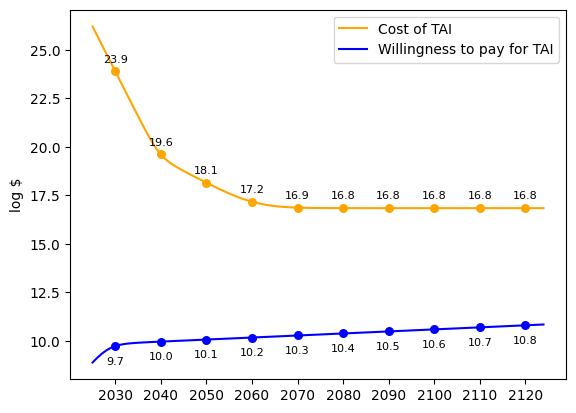

-
-
## SAMPLE RUN 20 ##

In this simulation:
* It takes 45.3 log FLOP (~2.0 trillion decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.7 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 25.6 log FLOP (~35.6 septillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~385.0 million).
* This doubles every 1.7 year to a max of 0.046474% of GDP (initially ~11.7 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 45.3 logFLOP which costs 27.1 log 2025$USD to buy vs. WTP at 8.6 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
2026 - TAI takes 45.1 logFLOP which costs 26.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.3 2025-log-eFLOP)
2027 - TAI takes 44.8 logFLOP which costs 26.3 log 2025$USD to buy vs. WTP at 8.9 (buys 27.4 log FLOP or 27.9 2025-log-eFLOP)
2028 - TAI takes 44.6 logFLOP wh

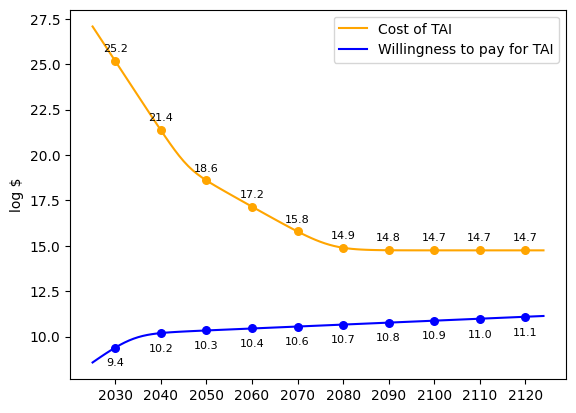

-
-
## SAMPLE RUN 21 ##

In this simulation:
* It takes 25.5 log FLOP (~31.6 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~18.5 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~183.6 sextillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~301.0 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 25.5 logFLOP which costs 6.2 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> No

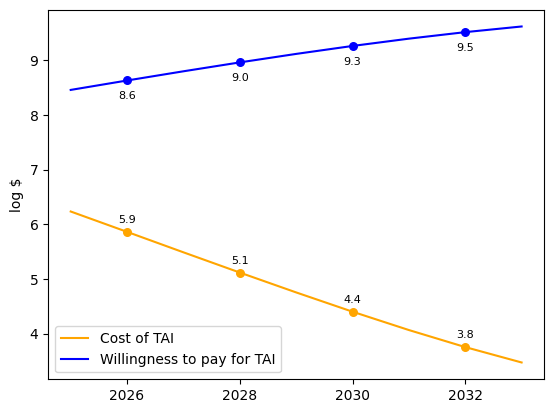

-
-
## SAMPLE RUN 22 ##

In this simulation:
* It takes 42.6 log FLOP (~4.0 billion decillion) for transformative capabilities.
* Every 2.6 years algorithms get 2x better, with 4.1 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.8 quintillion) per 2025$USD.
* Every 2.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.2 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 2.1 year to a max of 0.027975% of GDP (initially ~7.1 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 42.6 logFLOP which costs 23.4 log 2025$USD to buy vs. WTP at 9.0 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 42.5 logFLOP which costs 23.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.5 log FLOP or 28.6 2025-log-eFLOP)
2027 - TAI takes 42.4 logFLOP which costs 22.9 log 2025$USD to buy vs. WTP at 9.3 (buys 28.8 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 42.2 logFLOP whic

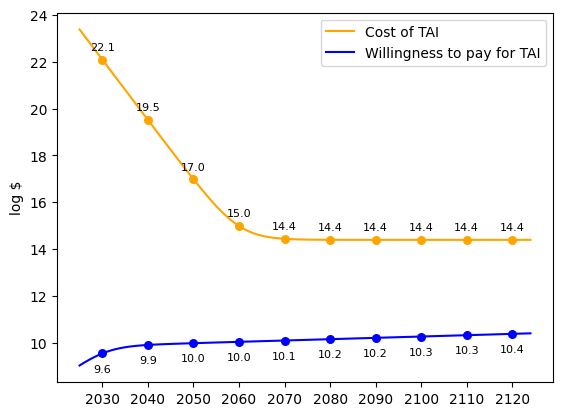

-
-
## SAMPLE RUN 23 ##

In this simulation:
* It takes 45.7 log FLOP (~5.0 trillion decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.3 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.7 log 2025$USD (~464.3 million).
* This doubles every 2.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.037x per year.
---
2025 - TAI takes 45.7 logFLOP which costs 26.6 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 45.5 logFLOP which costs 26.3 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 45.3 logFLOP which costs 26.0 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.6 2025-log-eFLOP)
2028 - TAI takes 45.1 logFLOP which 

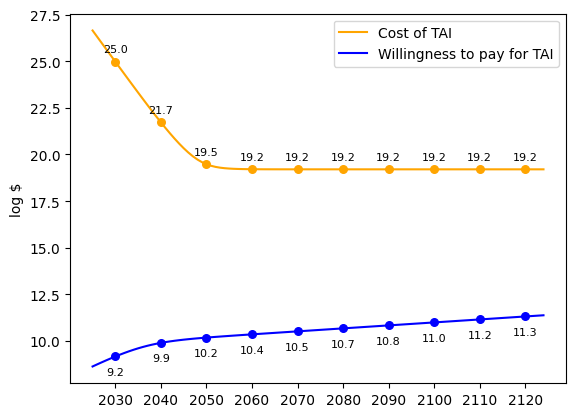

-
-
## SAMPLE RUN 24 ##

In this simulation:
* It takes 34.7 log FLOP (~50.1 decillion) for transformative capabilities.
* Every 0.6 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~14.7 septillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.6 million).
* This doubles every 2.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 34.7 logFLOP which costs 15.7 log 2025$USD to buy vs. WTP at 8.4 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 34.2 logFLOP which costs 15.0 log 2025$USD to buy vs. WTP at 8.5 (buys 27.6 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 33.7 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.9 log FLOP or 28.9 2025-log-eFLOP)
2028 - TAI takes 33.1 logFLOP which costs 1

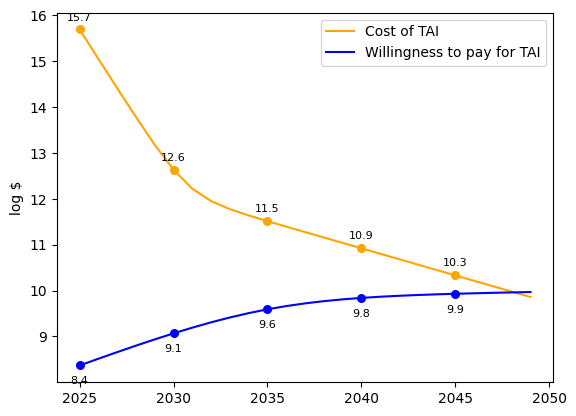

-
-
## SAMPLE RUN 25 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~10.4 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1.3 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~305.4 million).
* This doubles every 2.1 year to a max of 0.035734% of GDP (initially ~9.0 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 8.6 log 2025$USD to buy vs. WTP at 8.5 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 27.4 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.6 (buys 27.7 log FLOP or 28.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1817 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.5151 -> Nonscaling issue did not occur
-- data p_nonscaling_is

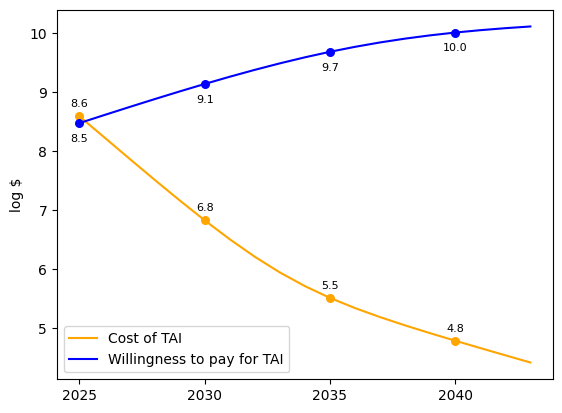

-
-
## SAMPLE RUN 26 ##

In this simulation:
* It takes 38.4 log FLOP (~251.2 thousand decillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.3 log FLOP (~22.2 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~620.6 million).
* This doubles every 1.5 year to a max of 0.14954% of GDP (initially ~37.7 billion 2025$USD).
* GDP grows at a rate of 1.014x per year.
---
2025 - TAI takes 38.4 logFLOP which costs 19.6 log 2025$USD to buy vs. WTP at 8.8 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 38.1 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 9.0 (buys 27.9 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 37.9 logFLOP which costs 18.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 37.6 logFLOP w

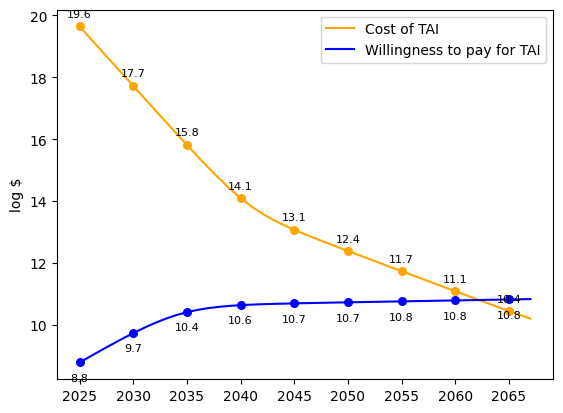

-
-
## SAMPLE RUN 27 ##

In this simulation:
* It takes 44.1 log FLOP (~125.9 billion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.8 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 26.2 log FLOP (~144.6 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~862.5 million).
* This doubles every 1.2 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 44.1 logFLOP which costs 25.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 43.7 logFLOP which costs 25.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.7 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 43.3 logFLOP which costs 24.6 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 42.8 logFLOP whic

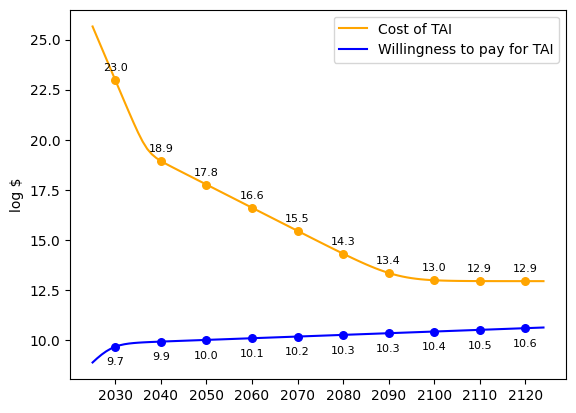

-
-
## SAMPLE RUN 28 ##

In this simulation:
* It takes 31.0 log FLOP (~10.0 nonillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~12.6 sextillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.5 billion).
* This doubles every 1.6 year to a max of 0.025% of GDP (initially ~6.4 billion 2025$USD).
* GDP grows at a rate of 1.023x per year.
---
2025 - TAI takes 31.0 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.2 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 30.8 logFLOP which costs 12.2 log 2025$USD to buy vs. WTP at 9.4 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 30.5 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 9.5 (buys 28.2 log FLOP or 28.7 2025-log-eFLOP)
2028 - TAI takes 30.3 logFLOP which costs 11.5

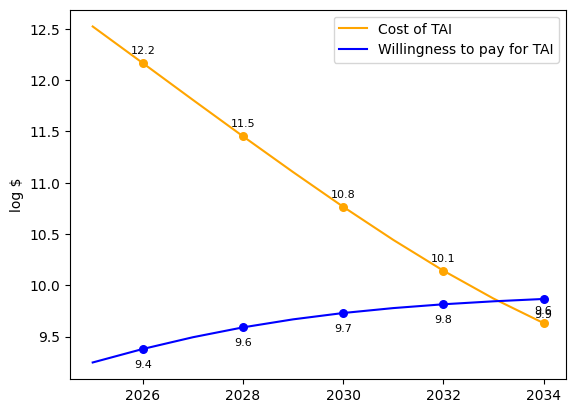

-
-
## SAMPLE RUN 29 ##

In this simulation:
* It takes 37.6 log FLOP (~39.8 thousand decillion) for transformative capabilities.
* Every 0.5 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~12.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~704.9 million).
* This doubles every 2.6 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 37.6 logFLOP which costs 18.5 log 2025$USD to buy vs. WTP at 8.8 (buys 27.9 log FLOP or 27.9 2025-log-eFLOP)
2026 - TAI takes 37.0 logFLOP which costs 17.8 log 2025$USD to buy vs. WTP at 8.9 (buys 28.1 log FLOP or 28.7 2025-log-eFLOP)
2027 - TAI takes 36.5 logFLOP which costs 17.2 log 2025$USD to buy vs. WTP at 9.0 (buys 28.3 log FLOP or 29.4 2025-log-eFLOP)
2028 - TAI takes 35.9 logFLOP which

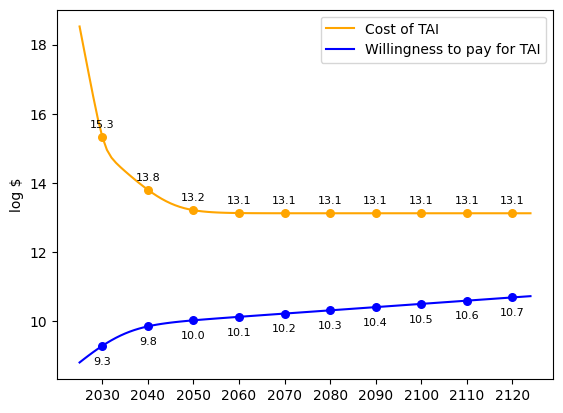

-
-
## SAMPLE RUN 30 ##

In this simulation:
* It takes 28.4 log FLOP (~25.1 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.8 quintillion) per 2025$USD.
* Every 3.1 years they get 2x cheaper, to a maximum of 24.5 log FLOP (~3.3 septillion) per 2025$USD.
* We are initially willing to pay 9.4 log 2025$USD (~2.4 billion).
* This doubles every 1.3 year to a max of 0.039451% of GDP (initially ~9.9 billion 2025$USD).
* GDP grows at a rate of 1.008x per year.
---
2025 - TAI takes 28.4 logFLOP which costs 9.6 log 2025$USD to buy vs. WTP at 9.3 (buys 28.1 log FLOP or 28.1 2025-log-eFLOP)
2026 - TAI takes 28.2 logFLOP which costs 9.2 log 2025$USD to buy vs. WTP at 9.5 (buys 28.4 log FLOP or 28.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1817 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.5151 -> Nonscaling delay occured
-- -- this delay is 1 years (to

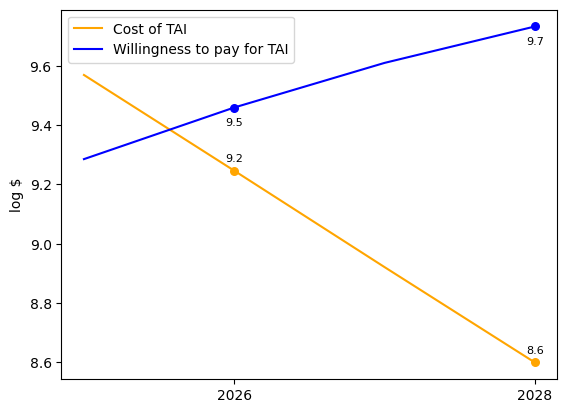

-
-
## SAMPLE RUN 31 ##

In this simulation:
* It takes 28.1 log FLOP (~12.6 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.3 log FLOP (~17.8 quintillion) per 2025$USD.
* Every 1.9 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~1.9 septillion) per 2025$USD.
* We are initially willing to pay 8.5 log 2025$USD (~310.3 million).
* This doubles every 2.3 year to a max of 0.065728% of GDP (initially ~16.5 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 28.1 logFLOP which costs 8.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 27.9 logFLOP which costs 8.5 log 2025$USD to buy vs. WTP at 8.6 (buys 28.0 log FLOP or 28.2 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1817 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.5151 -> Nonscaling issue did not occur
-- data p_nonscaling_

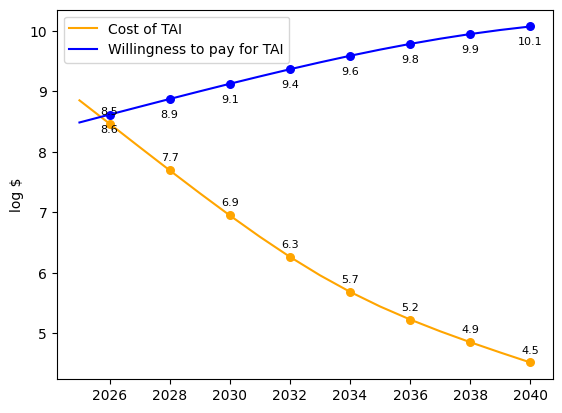

-
-
## SAMPLE RUN 32 ##

In this simulation:
* It takes 31.5 log FLOP (~31.6 nonillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~9.6 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~268.4 sextillion) per 2025$USD.
* We are initially willing to pay 9.3 log 2025$USD (~2.2 billion).
* This doubles every 1.3 year to a max of 0.06647% of GDP (initially ~16.8 billion 2025$USD).
* GDP grows at a rate of 1.009x per year.
---
2025 - TAI takes 31.5 logFLOP which costs 12.5 log 2025$USD to buy vs. WTP at 9.3 (buys 28.3 log FLOP or 28.3 2025-log-eFLOP)
2026 - TAI takes 31.2 logFLOP which costs 12.1 log 2025$USD to buy vs. WTP at 9.5 (buys 28.6 log FLOP or 28.9 2025-log-eFLOP)
2027 - TAI takes 30.8 logFLOP which costs 11.6 log 2025$USD to buy vs. WTP at 9.7 (buys 28.9 log FLOP or 29.6 2025-log-eFLOP)
2028 - TAI takes 30.5 logFLOP which costs 

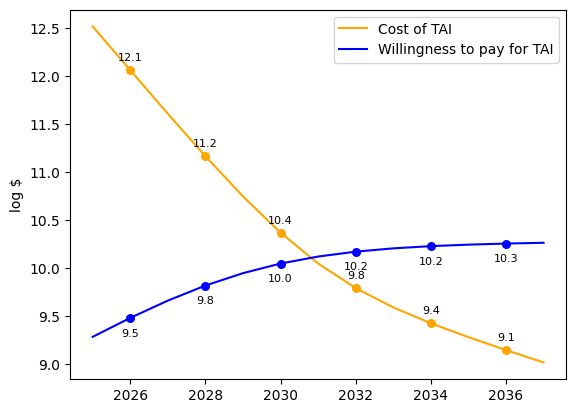

-
-
## SAMPLE RUN 33 ##

In this simulation:
* It takes 42.3 log FLOP (~2.0 billion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~24.9 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~250.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.4 million).
* This doubles every 2.4 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.007x per year.
---
2025 - TAI takes 42.3 logFLOP which costs 22.9 log 2025$USD to buy vs. WTP at 8.4 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 41.8 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 8.5 (buys 28.0 log FLOP or 28.5 2025-log-eFLOP)
2027 - TAI takes 41.4 logFLOP which costs 21.7 log 2025$USD to buy vs. WTP at 8.6 (buys 28.3 log FLOP or 29.2 2025-log-eFLOP)
2028 - TAI takes 40.9 logFLOP which

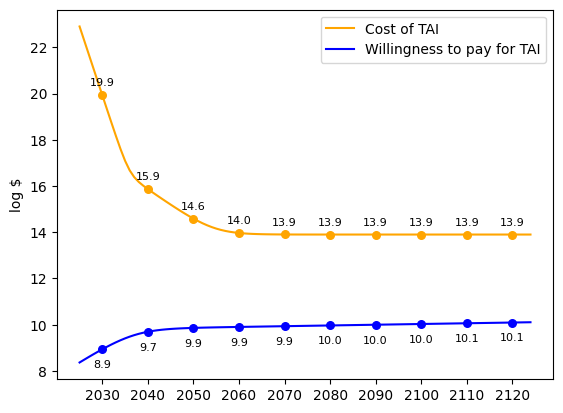

-
-
## SAMPLE RUN 34 ##

In this simulation:
* It takes 36.1 log FLOP (~1.3 thousand decillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.2 log FLOP (~1.5 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~250.4 million).
* This doubles every 2.4 year to a max of 0.327137% of GDP (initially ~82.4 billion 2025$USD).
* GDP grows at a rate of 1.021x per year.
---
2025 - TAI takes 36.1 logFLOP which costs 17.9 log 2025$USD to buy vs. WTP at 8.4 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
2026 - TAI takes 35.8 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 8.5 (buys 26.8 log FLOP or 27.1 2025-log-eFLOP)
2027 - TAI takes 35.5 logFLOP which costs 17.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.1 log FLOP or 27.6 2025-log-eFLOP)
2028 - TAI takes 35.3 logFLOP whi

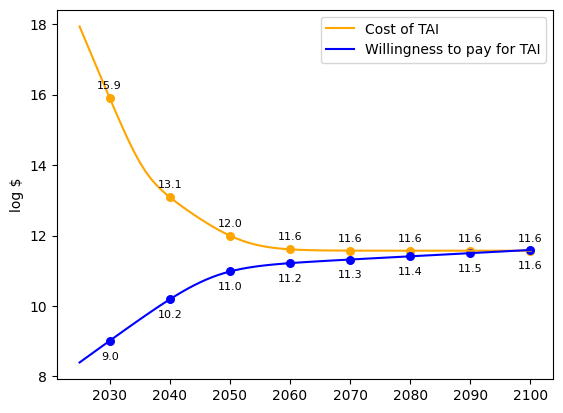

-
-
## SAMPLE RUN 35 ##

In this simulation:
* It takes 41.2 log FLOP (~158.5 million decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.0 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 26.0 log FLOP (~98.8 septillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.3 billion).
* This doubles every 2.3 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.04x per year.
---
2025 - TAI takes 41.2 logFLOP which costs 22.9 log 2025$USD to buy vs. WTP at 9.0 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 40.8 logFLOP which costs 22.4 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 40.5 logFLOP which costs 22.0 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 40.1 logFLOP which co

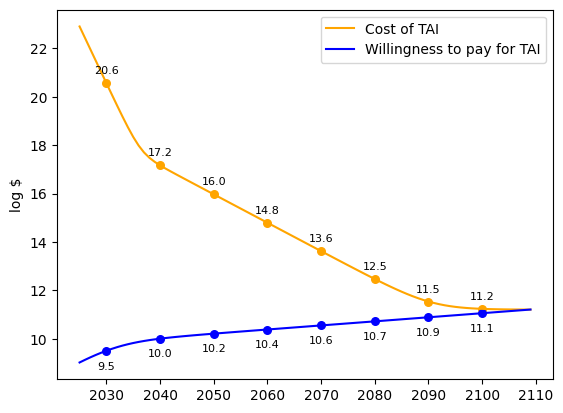

-
-
## SAMPLE RUN 36 ##

In this simulation:
* It takes 44.8 log FLOP (~631.0 billion decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3.5 log reductions possible.
* FLOP start at a cost of 19.4 log FLOP (~23.8 quintillion) per 2025$USD.
* Every 2.8 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~766.9 million).
* This doubles every 1.3 year to a max of 0.088822% of GDP (initially ~22.2 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 44.8 logFLOP which costs 25.4 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.2 2025-log-eFLOP)
2026 - TAI takes 44.4 logFLOP which costs 24.9 log 2025$USD to buy vs. WTP at 9.1 (buys 28.6 log FLOP or 29.0 2025-log-eFLOP)
2027 - TAI takes 44.0 logFLOP which costs 24.4 log 2025$USD to buy vs. WTP at 9.3 (buys 28.9 log FLOP or 29.7 2025-log-eFLOP)
2028 - TAI takes 43.6 logFLO

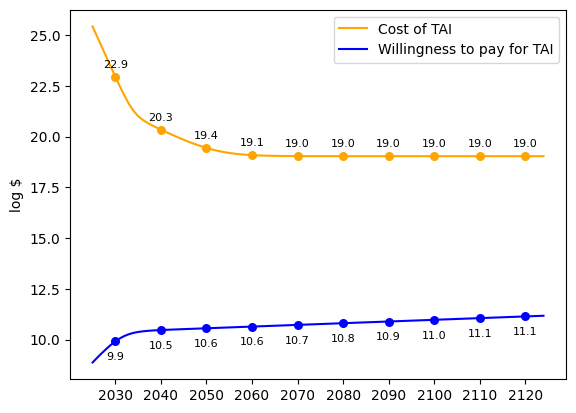

-
-
## SAMPLE RUN 37 ##

In this simulation:
* It takes 41.1 log FLOP (~125.9 million decillion) for transformative capabilities.
* Every 1.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.7 quintillion) per 2025$USD.
* Every 2.3 years they get 2x cheaper, to a maximum of 25.2 log FLOP (~15.2 septillion) per 2025$USD.
* We are initially willing to pay 9.2 log 2025$USD (~1.5 billion).
* This doubles every 2.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 41.1 logFLOP which costs 22.7 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.5 2025-log-eFLOP)
2026 - TAI takes 40.9 logFLOP which costs 22.3 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.0 2025-log-eFLOP)
2027 - TAI takes 40.7 logFLOP which costs 22.0 log 2025$USD to buy vs. WTP at 9.3 (buys 28.0 log FLOP or 28.4 2025-log-eFLOP)
2028 - TAI takes 40.4 logFLOP which c

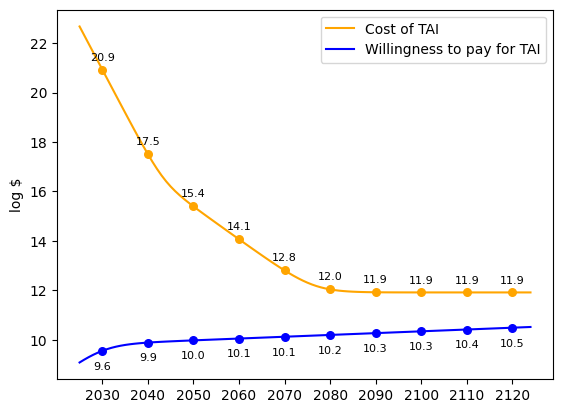

-
-
## SAMPLE RUN 38 ##

In this simulation:
* It takes 26.7 log FLOP (~501.2 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.9 quintillion) per 2025$USD.
* Every 2.7 years they get 2x cheaper, to a maximum of 25.8 log FLOP (~65.1 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~768.6 million).
* This doubles every 1.1 year to a max of 0.093891% of GDP (initially ~23.7 billion 2025$USD).
* GDP grows at a rate of 1.013x per year.
---
2025 - TAI takes 26.7 logFLOP which costs 8.0 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 ye

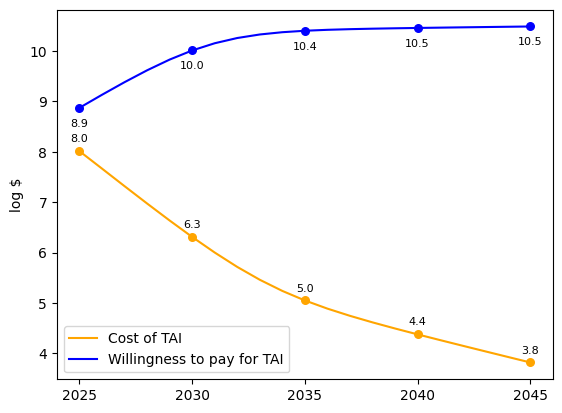

-
-
## SAMPLE RUN 39 ##

In this simulation:
* It takes 36.4 log FLOP (~2.5 thousand decillion) for transformative capabilities.
* Every 0.8 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.6 log FLOP (~4.3 septillion) per 2025$USD.
* We are initially willing to pay 8.9 log 2025$USD (~863.7 million).
* This doubles every 2.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.027x per year.
---
2025 - TAI takes 36.4 logFLOP which costs 18.0 log 2025$USD to buy vs. WTP at 8.9 (buys 27.3 log FLOP or 27.3 2025-log-eFLOP)
2026 - TAI takes 36.0 logFLOP which costs 17.5 log 2025$USD to buy vs. WTP at 9.0 (buys 27.5 log FLOP or 27.9 2025-log-eFLOP)
2027 - TAI takes 35.6 logFLOP which costs 17.0 log 2025$USD to buy vs. WTP at 9.1 (buys 27.7 log FLOP or 28.5 2025-log-eFLOP)
2028 - TAI takes 35.3 logFLOP which c

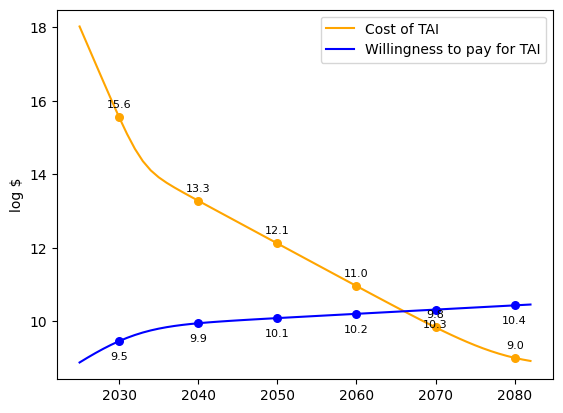

-
-
## SAMPLE RUN 40 ##

In this simulation:
* It takes 26.3 log FLOP (~199.5 septillion) for transformative capabilities.
* Every 1.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.5 log FLOP (~3.0 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~3.7 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~198.7 million).
* This doubles every 1.6 year to a max of 0.196615% of GDP (initially ~49.5 billion 2025$USD).
* GDP grows at a rate of 1.016x per year.
---
2025 - TAI takes 26.3 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.3 (buys 26.8 log FLOP or 26.8 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 2 years (total delay 2 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 6 yea

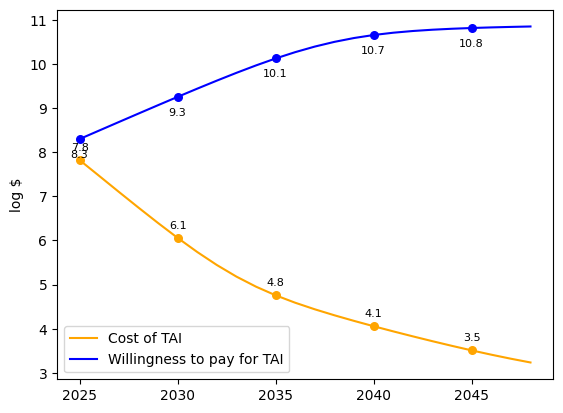

-
-
## SAMPLE RUN 41 ##

In this simulation:
* It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~1.9 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~14.1 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~904.2 million).
* This doubles every 1.9 year to a max of 0.0375% of GDP (initially ~9.4 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 28.8 logFLOP which costs 10.5 log 2025$USD to buy vs. WTP at 8.9 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 28.6 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.1 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 28.3 logFLOP which costs 9.8 log 2025$USD to buy vs. WTP at 9.2 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 28.1 logFLOP which costs 9.

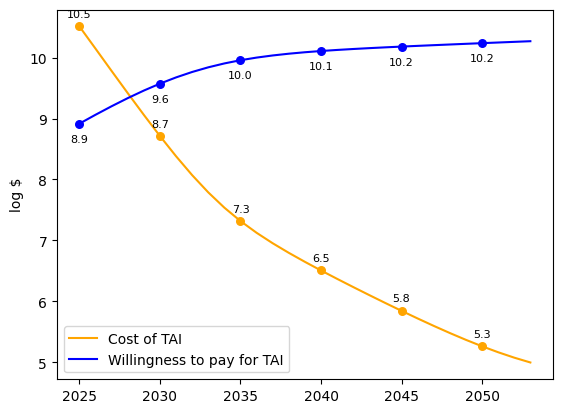

-
-
## SAMPLE RUN 42 ##

In this simulation:
* It takes 28.8 log FLOP (~63.1 octillion) for transformative capabilities.
* Every 1.6 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.6 quintillion) per 2025$USD.
* Every 3.0 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~44.9 sextillion) per 2025$USD.
* We are initially willing to pay 10.1 log 2025$USD (~11.3 billion).
* This doubles every 1.7 year to a max of 0.158991% of GDP (initially ~39.9 billion 2025$USD).
* GDP grows at a rate of 1.017x per year.
---
2025 - TAI takes 28.8 logFLOP which costs 10.1 log 2025$USD to buy vs. WTP at 9.9 (buys 28.6 log FLOP or 28.6 2025-log-eFLOP)
2026 - TAI takes 28.6 logFLOP which costs 9.9 log 2025$USD to buy vs. WTP at 10.1 (buys 28.8 log FLOP or 29.0 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.1817 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.5151 -> Nonscaling issue did not occur
-- data p_nonscalin

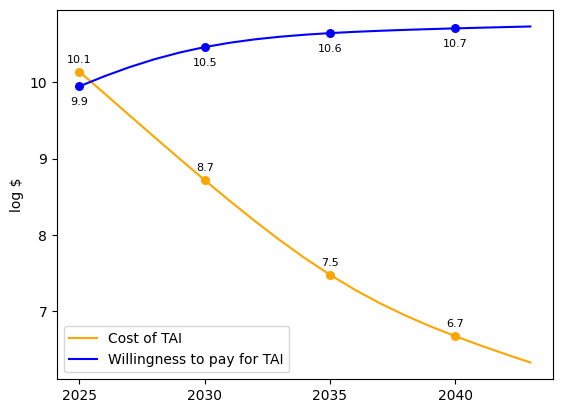

-
-
## SAMPLE RUN 43 ##

In this simulation:
* It takes 38.8 log FLOP (~631.0 thousand decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 19.0 log FLOP (~11.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~246.5 million).
* This doubles every 1.2 year to a max of 0.052907% of GDP (initially ~13.3 billion 2025$USD).
* GDP grows at a rate of 1.019x per year.
---
2025 - TAI takes 38.8 logFLOP which costs 19.8 log 2025$USD to buy vs. WTP at 8.4 (buys 27.4 log FLOP or 27.4 2025-log-eFLOP)
2026 - TAI takes 38.5 logFLOP which costs 19.3 log 2025$USD to buy vs. WTP at 8.6 (buys 27.8 log FLOP or 28.1 2025-log-eFLOP)
2027 - TAI takes 38.1 logFLOP which costs 18.8 log 2025$USD to buy vs. WTP at 8.9 (buys 28.2 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 37.8 logFLOP

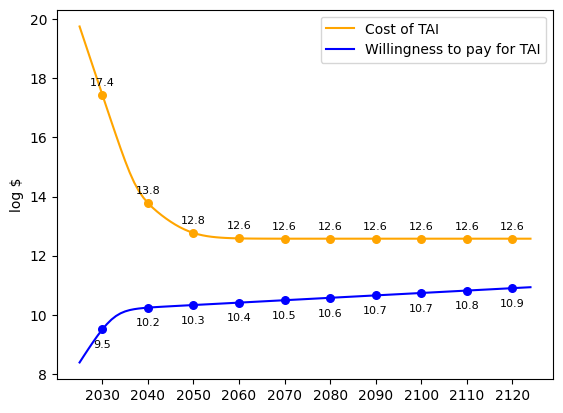

-
-
## SAMPLE RUN 44 ##

In this simulation:
* It takes 47.7 log FLOP (~501.2 trillion decillion) for transformative capabilities.
* Every 0.7 years algorithms get 2x better, with 5.1 log reductions possible.
* FLOP start at a cost of 18.7 log FLOP (~4.5 quintillion) per 2025$USD.
* Every 2.5 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~975.7 sextillion) per 2025$USD.
* We are initially willing to pay 9.0 log 2025$USD (~936.1 million).
* This doubles every 2.3 year to a max of 0.058414% of GDP (initially ~14.7 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 47.7 logFLOP which costs 29.0 log 2025$USD to buy vs. WTP at 8.9 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
2026 - TAI takes 47.3 logFLOP which costs 28.5 log 2025$USD to buy vs. WTP at 9.1 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 46.8 logFLOP which costs 27.9 log 2025$USD to buy vs. WTP at 9.2 (buys 28.1 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 46.4 logFL

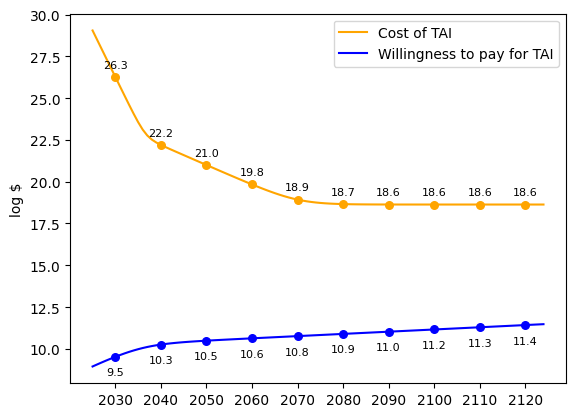

-
-
## SAMPLE RUN 45 ##

In this simulation:
* It takes 27.6 log FLOP (~4.0 octillion) for transformative capabilities.
* Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 26.4 log FLOP (~262.7 septillion) per 2025$USD.
* We are initially willing to pay 9.5 log 2025$USD (~3.5 billion).
* This doubles every 2.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.04x per year.
---
2025 - TAI takes 27.6 logFLOP which costs 9.3 log 2025$USD to buy vs. WTP at 9.4 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nonscali

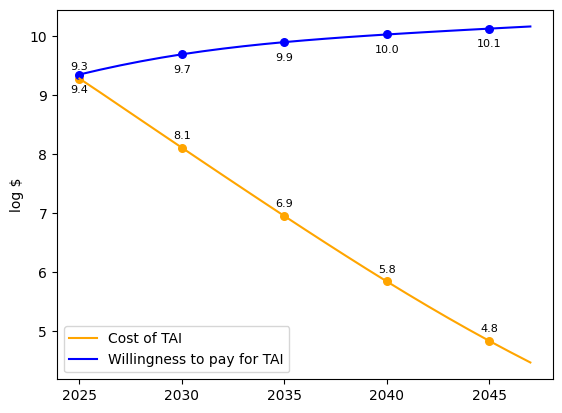

-
-
## SAMPLE RUN 46 ##

In this simulation:
* It takes 34.9 log FLOP (~79.4 decillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 3 log reductions possible.
* FLOP start at a cost of 18.1 log FLOP (~1.3 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9.0 sextillion) per 2025$USD.
* We are initially willing to pay 9.1 log 2025$USD (~1.2 billion).
* This doubles every 1.6 year to a max of 0.339245% of GDP (initially ~84.0 billion 2025$USD).
* GDP grows at a rate of 1.03x per year.
---
2025 - TAI takes 34.9 logFLOP which costs 16.8 log 2025$USD to buy vs. WTP at 9.1 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 34.7 logFLOP which costs 16.4 log 2025$USD to buy vs. WTP at 9.3 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 34.4 logFLOP which costs 16.1 log 2025$USD to buy vs. WTP at 9.5 (buys 27.8 log FLOP or 28.3 2025-log-eFLOP)
2028 - TAI takes 34.2 logFLOP which costs 15

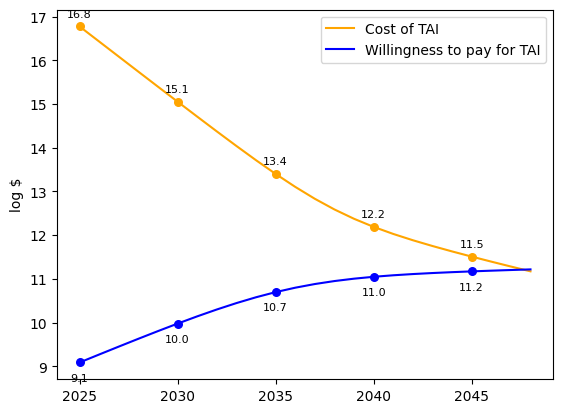

-
-
## SAMPLE RUN 47 ##

In this simulation:
* It takes 26.9 log FLOP (~794.3 septillion) for transformative capabilities.
* Every 3.2 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.1 log FLOP (~11.3 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5.1 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~384.8 million).
* This doubles every 2.3 year to a max of 0.045388% of GDP (initially ~11.5 billion 2025$USD).
* GDP grows at a rate of 1.04x per year.
---
2025 - TAI takes 26.9 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.6 (buys 27.6 log FLOP or 27.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
--

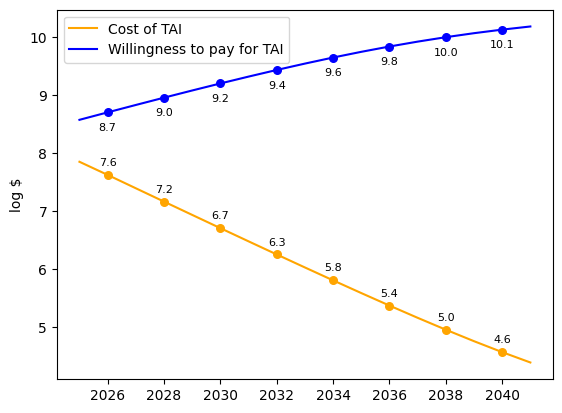

-
-
## SAMPLE RUN 48 ##

In this simulation:
* It takes 26.2 log FLOP (~158.5 septillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.4 log FLOP (~2.4 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 24.0 log FLOP (~1.0 septillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~573.3 million).
* This doubles every 1.1 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.031x per year.
---
2025 - TAI takes 26.2 logFLOP which costs 7.8 log 2025$USD to buy vs. WTP at 8.7 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling issue did not occur
-- robotics p_nonscaling_issue p=0.3 -> Nons

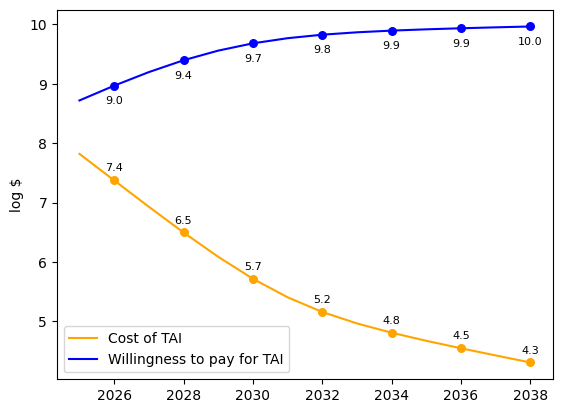

-
-
## SAMPLE RUN 49 ##

In this simulation:
* It takes 26.5 log FLOP (~316.2 septillion) for transformative capabilities.
* Every 1.3 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.3 log FLOP (~2.2 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~108.9 sextillion) per 2025$USD.
* We are initially willing to pay 8.3 log 2025$USD (~193.4 million).
* This doubles every 1.3 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.036x per year.
---
2025 - TAI takes 26.5 logFLOP which costs 8.2 log 2025$USD to buy vs. WTP at 8.3 (buys 26.6 log FLOP or 26.6 2025-log-eFLOP)
-- algorithms p_nonscaling_issue p=0.2 -> Nonscaling issue did not occur
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 3 years)
-- data p_nonscaling_issue p=0.7 -> Nonscaling delay occured
-- -- this delay is 3 years (total delay 4 years

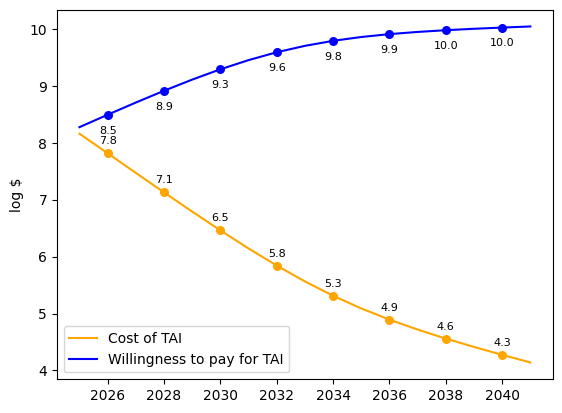

-
-
## SAMPLE RUN 50 ##

In this simulation:
* It takes 31.0 log FLOP (~10.0 nonillion) for transformative capabilities.
* Every 1.1 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 19.2 log FLOP (~16.6 quintillion) per 2025$USD.
* Every 2.9 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~118.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.6 log 2025$USD (~374.3 million).
* This doubles every 1.7 year to a max of 0.025% of GDP (initially ~6.2 billion 2025$USD).
* GDP grows at a rate of 1.035x per year.
---
2025 - TAI takes 31.0 logFLOP which costs 11.8 log 2025$USD to buy vs. WTP at 8.5 (buys 27.8 log FLOP or 27.8 2025-log-eFLOP)
2026 - TAI takes 30.7 logFLOP which costs 11.4 log 2025$USD to buy vs. WTP at 8.7 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 30.5 logFLOP which costs 11.0 log 2025$USD to buy vs. WTP at 8.9 (buys 28.3 log FLOP or 28.8 2025-log-eFLOP)
2028 - TAI takes 30.2 logFLOP which costs 

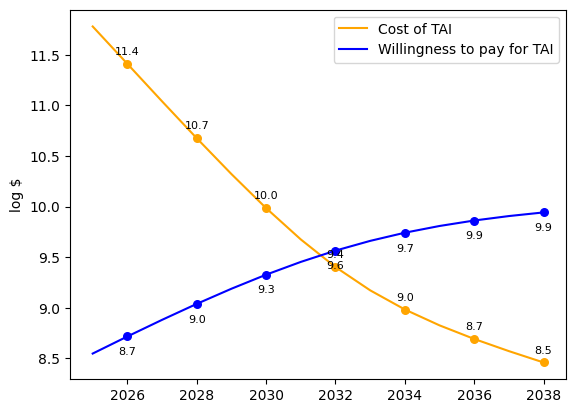

-
-
## SAMPLE RUN 51 ##

In this simulation:
* It takes 38.0 log FLOP (~100.0 thousand decillion) for transformative capabilities.
* Every 0.4 years algorithms get 2x better, with 4 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~5.9 quintillion) per 2025$USD.
* Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~153.0 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~241.6 million).
* This doubles every 1.0 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.022x per year.
---
2025 - TAI takes 38.0 logFLOP which costs 19.2 log 2025$USD to buy vs. WTP at 8.4 (buys 27.1 log FLOP or 27.1 2025-log-eFLOP)
2026 - TAI takes 37.3 logFLOP which costs 18.4 log 2025$USD to buy vs. WTP at 8.7 (buys 27.5 log FLOP or 28.2 2025-log-eFLOP)
2027 - TAI takes 36.7 logFLOP which costs 17.7 log 2025$USD to buy vs. WTP at 8.9 (buys 27.9 log FLOP or 29.3 2025-log-eFLOP)
2028 - TAI takes 36.0 logFLOP whi

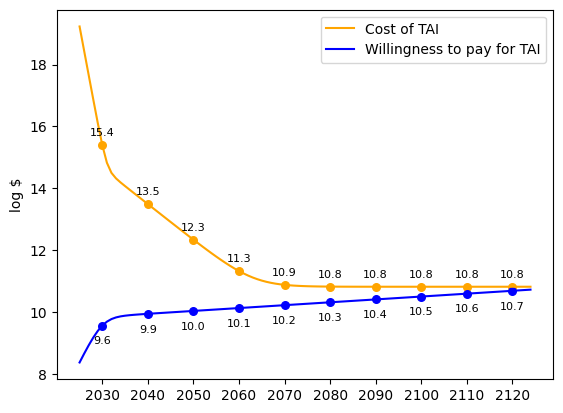

-
-
## SAMPLE RUN 52 ##

In this simulation:
* It takes 43.9 log FLOP (~79.4 billion decillion) for transformative capabilities.
* Every 0.9 years algorithms get 2x better, with 5 log reductions possible.
* FLOP start at a cost of 18.9 log FLOP (~7.1 quintillion) per 2025$USD.
* Every 2.2 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~94.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.8 log 2025$USD (~705.3 million).
* This doubles every 1.5 year to a max of 0.025% of GDP (initially ~6.3 billion 2025$USD).
* GDP grows at a rate of 1.025x per year.
---
2025 - TAI takes 43.9 logFLOP which costs 25.0 log 2025$USD to buy vs. WTP at 8.8 (buys 27.7 log FLOP or 27.7 2025-log-eFLOP)
2026 - TAI takes 43.6 logFLOP which costs 24.6 log 2025$USD to buy vs. WTP at 9.0 (buys 28.0 log FLOP or 28.3 2025-log-eFLOP)
2027 - TAI takes 43.2 logFLOP which costs 24.1 log 2025$USD to buy vs. WTP at 9.2 (buys 28.3 log FLOP or 29.0 2025-log-eFLOP)
2028 - TAI takes 42.9 logFLOP which 

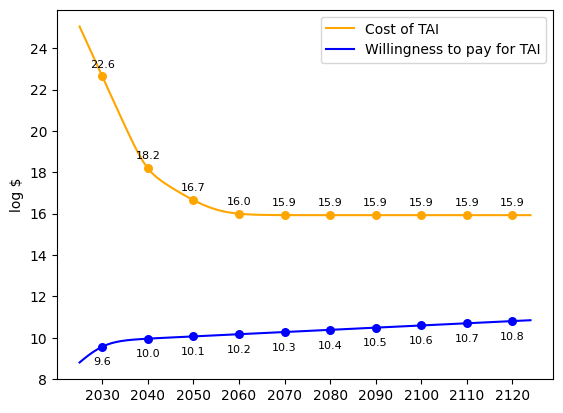

-
-
## SAMPLE RUN 53 ##

In this simulation:
* It takes 33.2 log FLOP (~1.6 decillion) for transformative capabilities.
* Every 1.5 years algorithms get 2x better, with 2 log reductions possible.
* FLOP start at a cost of 18.8 log FLOP (~6.4 quintillion) per 2025$USD.
* Every 2.4 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19.4 sextillion) per 2025$USD.
* We are initially willing to pay 8.4 log 2025$USD (~247.8 million).
* This doubles every 1.7 year to a max of 0.073558% of GDP (initially ~18.2 billion 2025$USD).
* GDP grows at a rate of 1.033x per year.
---
2025 - TAI takes 33.2 logFLOP which costs 14.4 log 2025$USD to buy vs. WTP at 8.4 (buys 27.2 log FLOP or 27.2 2025-log-eFLOP)
2026 - TAI takes 33.0 logFLOP which costs 14.1 log 2025$USD to buy vs. WTP at 8.6 (buys 27.5 log FLOP or 27.7 2025-log-eFLOP)
2027 - TAI takes 32.8 logFLOP which costs 13.7 log 2025$USD to buy vs. WTP at 8.7 (buys 27.8 log FLOP or 28.2 2025-log-eFLOP)
2028 - TAI takes 32.6 logFLOP which costs

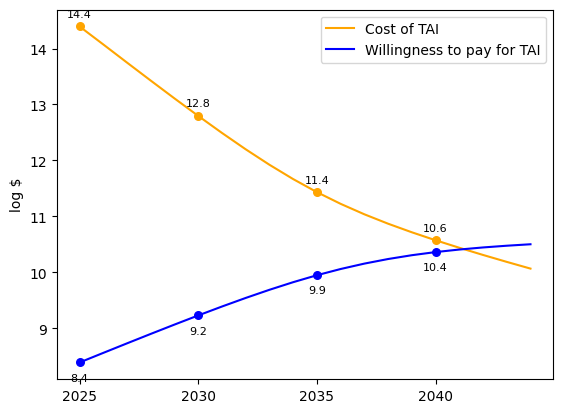

In [14]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)

In [15]:
print('File last ran: {}'.format(dt.now()))

File last ran: 2024-04-26 10:15:50.372987
